# Validation Sample

## **import Librarys**

In [ ]:
!pip install japanize_matplotlib
!pip install iterative-stratification

In [2]:
import os
import numpy as np
import pandas as pd
import random
from collections import Counter, defaultdict  

# import sklearn datasets
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import LabelEncoder

# import plt and sns
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
%matplotlib inline

In [3]:
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    GroupShuffleSplit,
    GroupKFold,
    StratifiedShuffleSplit,
    StratifiedGroupKFold,
)
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [4]:
# random_seed の固定
def seed_everything(seed_value): 
    random.seed(seed_value) # for built-in random
    np.random.seed(seed_value) # for numpy.random
    os.environ['PYTHONHASHSEED'] = str(seed_value) # for hash seed
random_state=42
seed_everything(random_state)

## **hold-out / K-fold**

In [5]:
def KFold_def(df, n_splits, *, shuffle=False, random_state=None):
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    for fold, (tr_idx, va_idx) in enumerate(kf.split(df)):
        df.loc[tr_idx, f"fold_{fold}"] = 0
        df.loc[va_idx, f"fold_{fold}"] = 1
    return df

In [6]:
# データの準備
housing = fetch_california_housing()
x = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.DataFrame(housing.target, columns=["target"])
data_ = pd.concat([x, y], axis=1)
# 見栄えから500行だけ使う
data_ = data_[:500]

### hold-out

In [7]:
split = 5
data = KFold_def(data_, split)

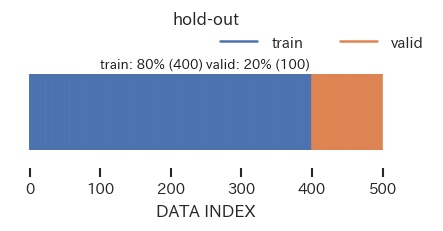

In [8]:
fold=split-1

sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})
dpi=120
ax = plt.subplots(figsize=(500/dpi, 100/dpi), dpi=dpi, facecolor="w")

g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=True)

# legend
## label name
legend = g.get_legend()
labels = [] if legend is None else [str(x._text) for x in legend.texts]
handles = [] if legend is None else legend.legendHandles
g.legend(handles, ["train", "valid"], title=None)
## move legend
sns.move_legend(g, "lower center", bbox_to_anchor=(.8, 1.1), ncol=2, frameon=False)
## set font size legend
plt.setp(g.get_legend().get_texts(), fontsize='9')
plt.setp(g.get_legend().get_title(), fontsize='9') 

# tick
g.tick_params(bottom=True, left=False, right=False, top=False,
              labelbottom=True, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=(0,10), trim=False)
# set title
g.set_title(f'hold-out', fontsize=10, pad=30)
# xlabel
g.set_xlabel("DATA INDEX", fontsize=10)
# ylabel
g.set_ylabel(None, fontsize=7)

# Add text
g.text(len(data)/2 -len(data)*0.3, 0.3, f'train: {len(data[data[f"fold_{fold}"] == 0])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 0])})', fontsize=8, color='k')
g.text(len(data)/2 , 0.3, f'valid: {len(data[data[f"fold_{fold}"] == 1])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 1])})', fontsize=8, color='k')

plt.show()

validationデータの量を指定する

In [9]:
valid_num = 120

data = data_.copy()
data['fold_manual'] = 0
data.loc[len(data)-valid_num:, 'fold_manual'] = 1
# data.loc[:valid_num-1, 'fold_manual'] = 1

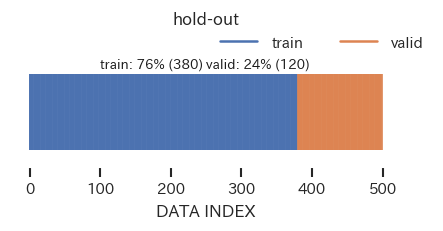

In [10]:
sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
ax = plt.subplots(figsize=(500/dpi, 100/dpi), dpi=dpi, facecolor="w")

g = sns.rugplot(data=data, x=data.index, hue=f"fold_manual", height=1, legend=True)

# legend
## label name
legend = g.get_legend()
labels = [] if legend is None else [str(x._text) for x in legend.texts]
handles = [] if legend is None else legend.legendHandles
g.legend(handles, ["train", "valid"], title=None)
## move legend
sns.move_legend(g, "lower center", bbox_to_anchor=(.8, 1.1), ncol=2, frameon=False)
## set font size legend
plt.setp(g.get_legend().get_texts(), fontsize='9')
plt.setp(g.get_legend().get_title(), fontsize='9') 

# tick
g.tick_params(bottom=True, left=False, right=False, top=False,
              labelbottom=True, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=(0,10), trim=False)
# set title
g.set_title(f'hold-out', fontsize=10, pad=30)
# xlabel
g.set_xlabel("DATA INDEX", fontsize=10)
# ylabel
g.set_ylabel(None, fontsize=7)

# Add text
g.text(len(data)/2 -len(data)*0.3, 0.3, f'train: {len(data[data[f"fold_manual"] == 0])/len(data)*100:.0f}% ({len(data[data[f"fold_manual"] == 0])})', fontsize=8, color='k')
g.text(len(data)/2 , 0.3, f'valid: {len(data[data[f"fold_manual"] == 1])/len(data)*100:.0f}% ({len(data[data[f"fold_manual"] == 1])})', fontsize=8, color='k')

plt.show()

### K-Fold

shuffle=False

In [11]:
split = 5
data = KFold_def(data_, split)

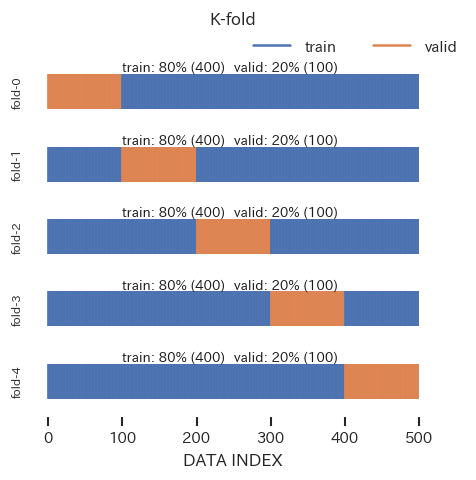

In [12]:
folds=[i for i in range(split)]

sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
nr, nc = len(folds), 1
fig, axes = plt.subplots(nr, nc, figsize=(500/dpi, 100*5/dpi), dpi=dpi, tight_layout=True, facecolor="w")

for i, (fold, ax) in enumerate(zip(folds, axes)):
  if i == 0:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=True, ax=ax)

    # legend
    ## label name
    legend = g.get_legend()
    labels = [] if legend is None else [str(x._text) for x in legend.texts]
    handles = [] if legend is None else legend.legendHandles
    g.legend(handles, ["train", "valid"], title=None)
    ## move legend
    sns.move_legend(g, "lower center", bbox_to_anchor=(.8, 1.1), ncol=2, frameon=False)
    ## set font size legend
    plt.setp(g.get_legend().get_texts(), fontsize='9')
    plt.setp(g.get_legend().get_title(), fontsize='9') 
  else:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=False, ax=ax)

  # set title
  if i == 0:
    g.set_title(f'K-fold', fontsize=10, pad=30)

  if i == len(folds)-1:
    # xlabel
    g.set_xlabel("DATA INDEX", fontsize=10)
    # tick
    g.tick_params(bottom=True, left=False, right=False, top=False,
                  labelbottom=True, labelleft=False, labelright=False, labeltop=False,
                  labelsize=9)
    sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=(0,10), trim=False)
  else:
    # tick
    g.tick_params(bottom=False, left=False, right=False, top=False,
                  labelbottom=False, labelleft=False, labelright=False, labeltop=False,
                  labelsize=9)
    sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
  # ylabel
  g.set_ylabel(f'fold-{fold}', fontsize=7)

  # Add text
  g.text(len(data)/2 -len(data)*0.3, 0.3, f'train: {len(data[data[f"fold_{fold}"] == 0])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 0])})', fontsize=8, color='k')
  g.text(len(data)/2 , 0.3, f'valid: {len(data[data[f"fold_{fold}"] == 1])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 1])})', fontsize=8, color='k')

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

shuffle=True

In [13]:
split = 5
data = KFold_def(data_, split, shuffle=True, random_state=random_state)

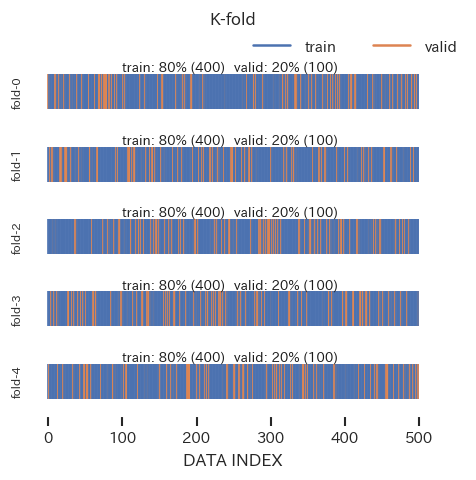

In [14]:
folds=[i for i in range(split)]

sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
nr, nc = len(folds), 1
fig, axes = plt.subplots(nr, nc, figsize=(500/dpi, 100*5/dpi), dpi=dpi, tight_layout=True, facecolor="w")

for i, (fold, ax) in enumerate(zip(folds, axes)):
  if i == 0:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=True, ax=ax)

    # legend
    ## label name
    legend = g.get_legend()
    labels = [] if legend is None else [str(x._text) for x in legend.texts]
    handles = [] if legend is None else legend.legendHandles
    g.legend(handles, ["train", "valid"], title=None)
    ## move legend
    sns.move_legend(g, "lower center", bbox_to_anchor=(.8, 1.1), ncol=2, frameon=False)
    ## set font size legend
    plt.setp(g.get_legend().get_texts(), fontsize='9')
    plt.setp(g.get_legend().get_title(), fontsize='9') 
  else:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=False, ax=ax)

  # set title
  if i == 0:
    g.set_title(f'K-fold', fontsize=10, pad=30)

  if i == len(folds)-1:
    # xlabel
    g.set_xlabel("DATA INDEX", fontsize=10)
    # tick
    g.tick_params(bottom=True, left=False, right=False, top=False,
                  labelbottom=True, labelleft=False, labelright=False, labeltop=False,
                  labelsize=9)
    sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=(0,10), trim=False)
  else:
    # tick
    g.tick_params(bottom=False, left=False, right=False, top=False,
                  labelbottom=False, labelleft=False, labelright=False, labeltop=False,
                  labelsize=9)
    sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
  # ylabel
  g.set_ylabel(f'fold-{fold}', fontsize=7)

  # Add text
  g.text(len(data)/2 -len(data)*0.3, 0.3, f'train: {len(data[data[f"fold_{fold}"] == 0])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 0])})', fontsize=8, color='k')
  g.text(len(data)/2 , 0.3, f'valid: {len(data[data[f"fold_{fold}"] == 1])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 1])})', fontsize=8, color='k')

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

## **Group K-Fold**

In [15]:
def GroupKFold_def(df, ID_col_name, n_splits, *, shuffle=False, random_state=None):
    df["fold"] = 99
    _ids = df[ID_col_name]
    unique_ids = _ids.unique()
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    for fold, (tr_id_idx, va_id_idx) in enumerate(kf.split(unique_ids)):
        tr_id_grps, va_id_grps = unique_ids[tr_id_idx], unique_ids[va_id_idx]
        tr_idx = _ids.isin(tr_id_grps)
        va_idx = _ids.isin(va_id_grps)
        df.loc[tr_idx, f"fold_{fold}"] = 0
        df.loc[va_idx, f"fold_{fold}"] = 1
        df.loc[va_idx, f"fold"] = fold
    return df

In [16]:
# データの準備
data_ = sns.load_dataset('exercise')

shuffle=False

In [17]:
split = 3
data = GroupKFold_def(data_, 'id', split)

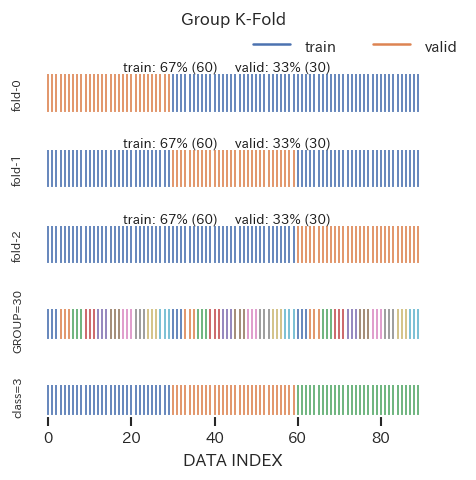

In [18]:
folds=[i for i in range(split)]

sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
nr, nc = len(folds)+2, 1
fig, axes = plt.subplots(nr, nc, figsize=(500/dpi, 100*5/dpi), dpi=dpi, tight_layout=True, facecolor="w")

for i, (fold, ax) in enumerate(zip(folds, axes)):
  if i == 0:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=True, ax=ax)

    # legend
    ## label name
    legend = g.get_legend()
    labels = [] if legend is None else [str(x._text) for x in legend.texts]
    handles = [] if legend is None else legend.legendHandles
    g.legend(handles, ["train", "valid"], title=None)
    ## move legend
    sns.move_legend(g, "lower center", bbox_to_anchor=(.8, 1.1), ncol=2, frameon=False)
    ## set font size legend
    plt.setp(g.get_legend().get_texts(), fontsize='9')
    plt.setp(g.get_legend().get_title(), fontsize='9') 
  else:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=False, ax=ax)

  # set title
  if i == 0:
    g.set_title(f'Group K-Fold', fontsize=10, pad=30)

  # tick
  g.tick_params(bottom=False, left=False, right=False, top=False,
                labelbottom=False, labelleft=False, labelright=False, labeltop=False,
                labelsize=9)
  sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

  # ylabel
  g.set_ylabel(f'fold-{fold}', fontsize=7)

  # Add text
  g.text(len(data)/2 -len(data)*0.3, 0.3, f'train: {len(data[data[f"fold_{fold}"] == 0])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 0])})', fontsize=8, color='k')
  g.text(len(data)/2 , 0.3, f'valid: {len(data[data[f"fold_{fold}"] == 1])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 1])})', fontsize=8, color='k')


# plot ID
ax = axes[-2]
g = sns.rugplot(data=data, x=data.index, hue=f"id", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.id.unique())))
## tick
g.tick_params(bottom=False, left=False, right=False, top=False,
              labelbottom=False, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
## ylabel
g.set_ylabel(f'GROUP={len(data_.id.unique())}', fontsize=7)


# plot kind
ax = axes[-1]
g = sns.rugplot(data=data, x=data.index, hue=f"kind", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.kind.unique())))
## tick
g.tick_params(bottom=True, left=False, right=False, top=False,
              labelbottom=True, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
## xlabel
g.set_xlabel("DATA INDEX", fontsize=10)
## ylabel
g.set_ylabel(f'class={len(data_.kind.unique())}', fontsize=7)

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

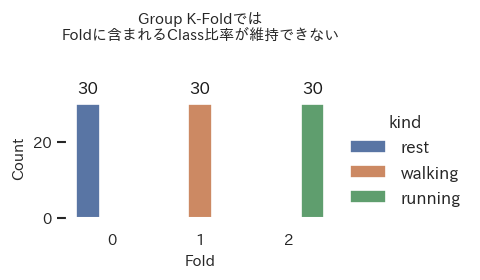

In [19]:
sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
ax = plt.subplots(figsize=(500/dpi, 300/dpi), dpi=dpi, tight_layout=True, facecolor="w")

g = sns.countplot(data=data, x="fold", hue="kind")
# set title
g.set_title(f'Group K-Foldでは\nFoldに含まれるClass比率が維持できない', fontsize=9, pad=35)
## move legend
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), ncol=1, frameon=False)
## set font size legend
plt.setp(g.get_legend().get_texts(), fontsize='10')
plt.setp(g.get_legend().get_title(), fontsize='10')
## tick
g.tick_params(bottom=False, left=True, right=False, top=False,
              labelbottom=True, labelleft=True, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
# xlabel ylabel
g.set_xlabel(f'Fold', fontsize=9)
g.set_ylabel(f'Count', fontsize=9)
for p in g.patches:
  g.annotate(format(p.get_height(), '.0f'),
             (p.get_x() + p.get_width() / 2., p.get_height()), 
             ha = 'center', 
             va = 'center', 
             xytext = (0, 9), 
             textcoords = 'offset points',
             fontsize = 10,
             color = 'k')
plt.show()

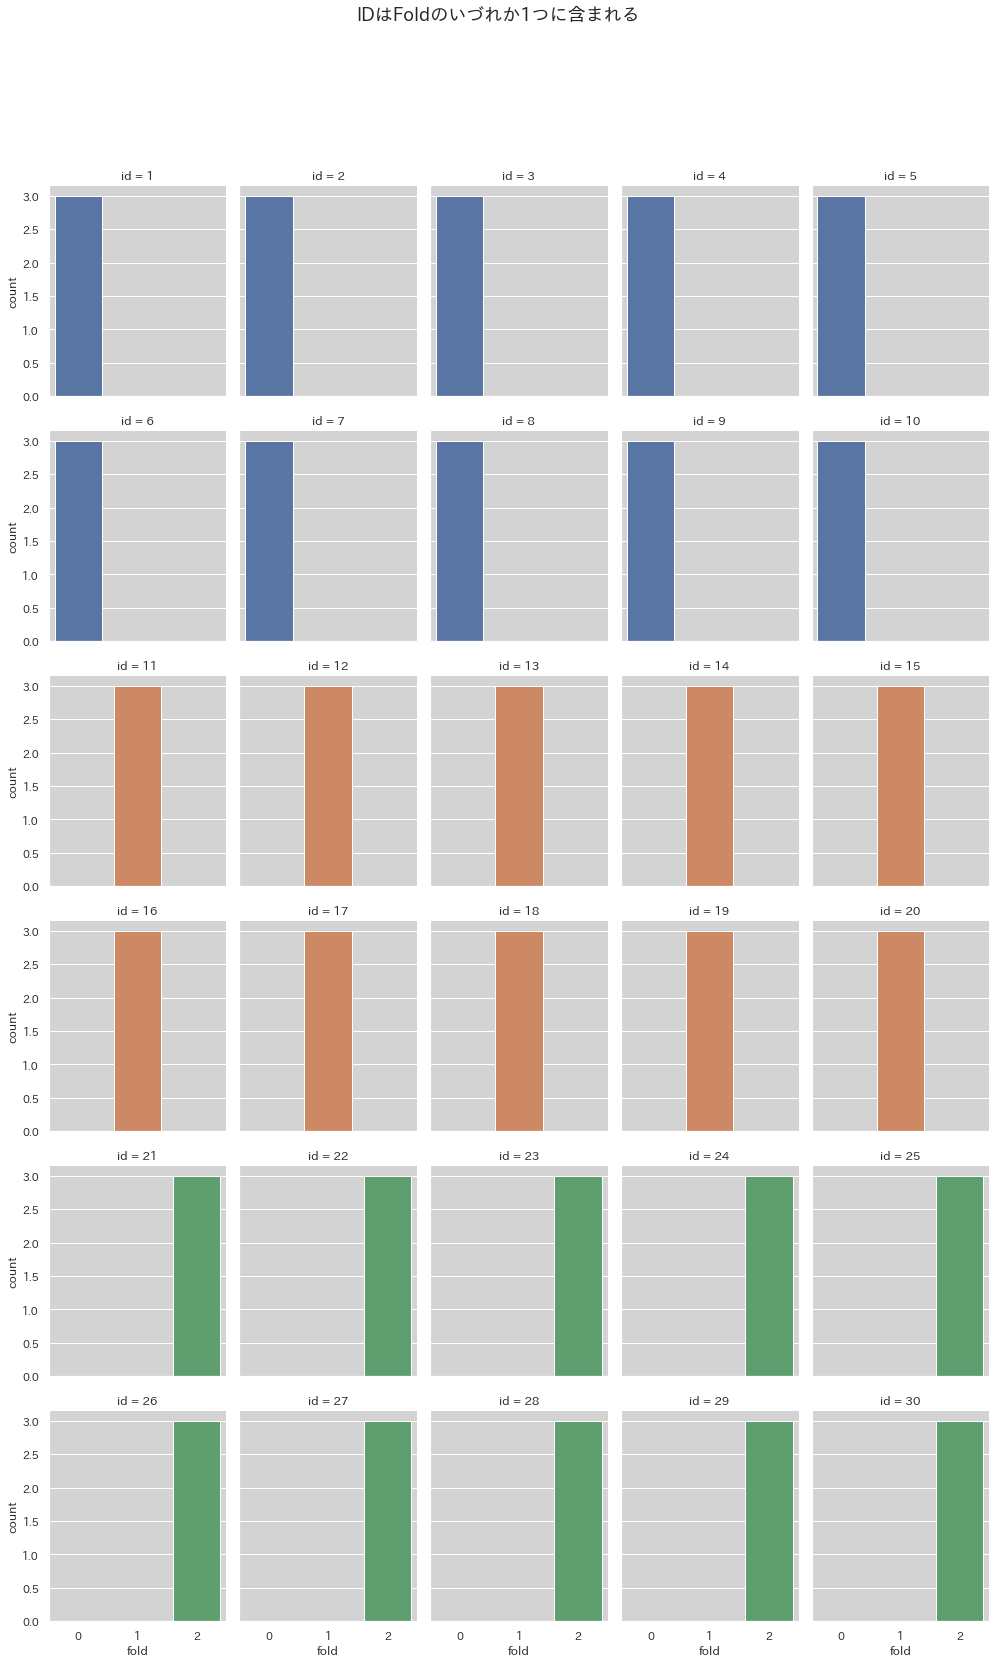

In [20]:
sns.set(rc={'axes.facecolor':'lightgrey','figure.facecolor':'white','font.family':'IPAexGothic'})
g = sns.catplot(data=data, x="fold", col="id", col_wrap=5,
                kind="count", height=3.5, aspect=.8)
# set title
g.fig.suptitle("IDはFoldのいづれか1つに含まれる", size=18, weight=2, x=.5, y=1.1)
plt.show()

shuffle=True

In [21]:
split = 3
data = GroupKFold_def(data_, 'id', split, shuffle=True, random_state=random_state)

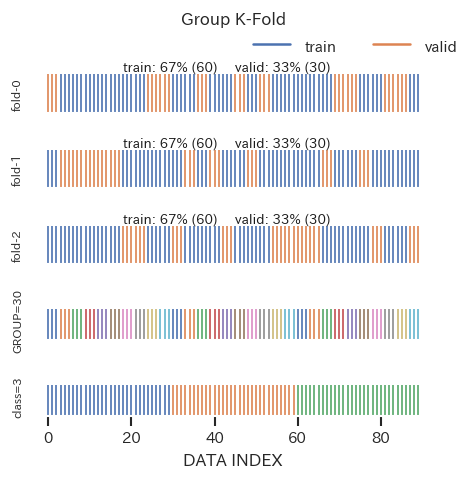

In [22]:
folds=[i for i in range(split)]

sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
nr, nc = len(folds)+2, 1
fig, axes = plt.subplots(nr, nc, figsize=(500/dpi, 100*5/dpi), dpi=dpi, tight_layout=True, facecolor="w")

for i, (fold, ax) in enumerate(zip(folds, axes)):
  if i == 0:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=True, ax=ax)

    # legend
    ## label name
    legend = g.get_legend()
    labels = [] if legend is None else [str(x._text) for x in legend.texts]
    handles = [] if legend is None else legend.legendHandles
    g.legend(handles, ["train", "valid"], title=None)
    ## move legend
    sns.move_legend(g, "lower center", bbox_to_anchor=(.8, 1.1), ncol=2, frameon=False)
    ## set font size legend
    plt.setp(g.get_legend().get_texts(), fontsize='9')
    plt.setp(g.get_legend().get_title(), fontsize='9') 
  else:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=False, ax=ax)

  # set title
  if i == 0:
    g.set_title(f'Group K-Fold', fontsize=10, pad=30)

  # tick
  g.tick_params(bottom=False, left=False, right=False, top=False,
                labelbottom=False, labelleft=False, labelright=False, labeltop=False,
                labelsize=9)
  sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

  # ylabel
  g.set_ylabel(f'fold-{fold}', fontsize=7)

  # Add text
  g.text(len(data)/2 -len(data)*0.3, 0.3, f'train: {len(data[data[f"fold_{fold}"] == 0])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 0])})', fontsize=8, color='k')
  g.text(len(data)/2 , 0.3, f'valid: {len(data[data[f"fold_{fold}"] == 1])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 1])})', fontsize=8, color='k')


# plot ID
ax = axes[-2]
g = sns.rugplot(data=data, x=data.index, hue=f"id", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.id.unique())))
## tick
g.tick_params(bottom=False, left=False, right=False, top=False,
              labelbottom=False, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
## ylabel
g.set_ylabel(f'GROUP={len(data_.id.unique())}', fontsize=7)


# plot kind
ax = axes[-1]
g = sns.rugplot(data=data, x=data.index, hue=f"kind", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.kind.unique())))
## tick
g.tick_params(bottom=True, left=False, right=False, top=False,
              labelbottom=True, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
## xlabel
g.set_xlabel("DATA INDEX", fontsize=10)
## ylabel
g.set_ylabel(f'class={len(data_.kind.unique())}', fontsize=7)

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

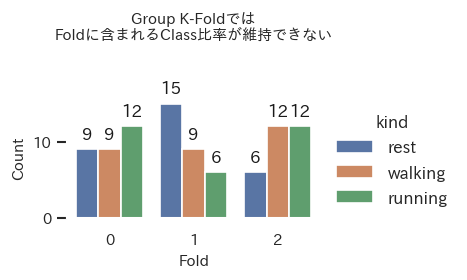

In [23]:
sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
ax = plt.subplots(figsize=(500/dpi, 300/dpi), dpi=dpi, tight_layout=True, facecolor="w")

g = sns.countplot(data=data, x="fold", hue="kind")
# set title
g.set_title(f'Group K-Foldでは\nFoldに含まれるClass比率が維持できない', fontsize=9, pad=35)
## move legend
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), ncol=1, frameon=False)
## set font size legend
plt.setp(g.get_legend().get_texts(), fontsize='10')
plt.setp(g.get_legend().get_title(), fontsize='10')
## tick
g.tick_params(bottom=False, left=True, right=False, top=False,
              labelbottom=True, labelleft=True, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
# xlabel ylabel
g.set_xlabel(f'Fold', fontsize=9)
g.set_ylabel(f'Count', fontsize=9)
for p in g.patches:
  g.annotate(format(p.get_height(), '.0f'),
             (p.get_x() + p.get_width() / 2., p.get_height()), 
             ha = 'center', 
             va = 'center', 
             xytext = (0, 9), 
             textcoords = 'offset points',
             fontsize = 10,
             color = 'k')
plt.show()

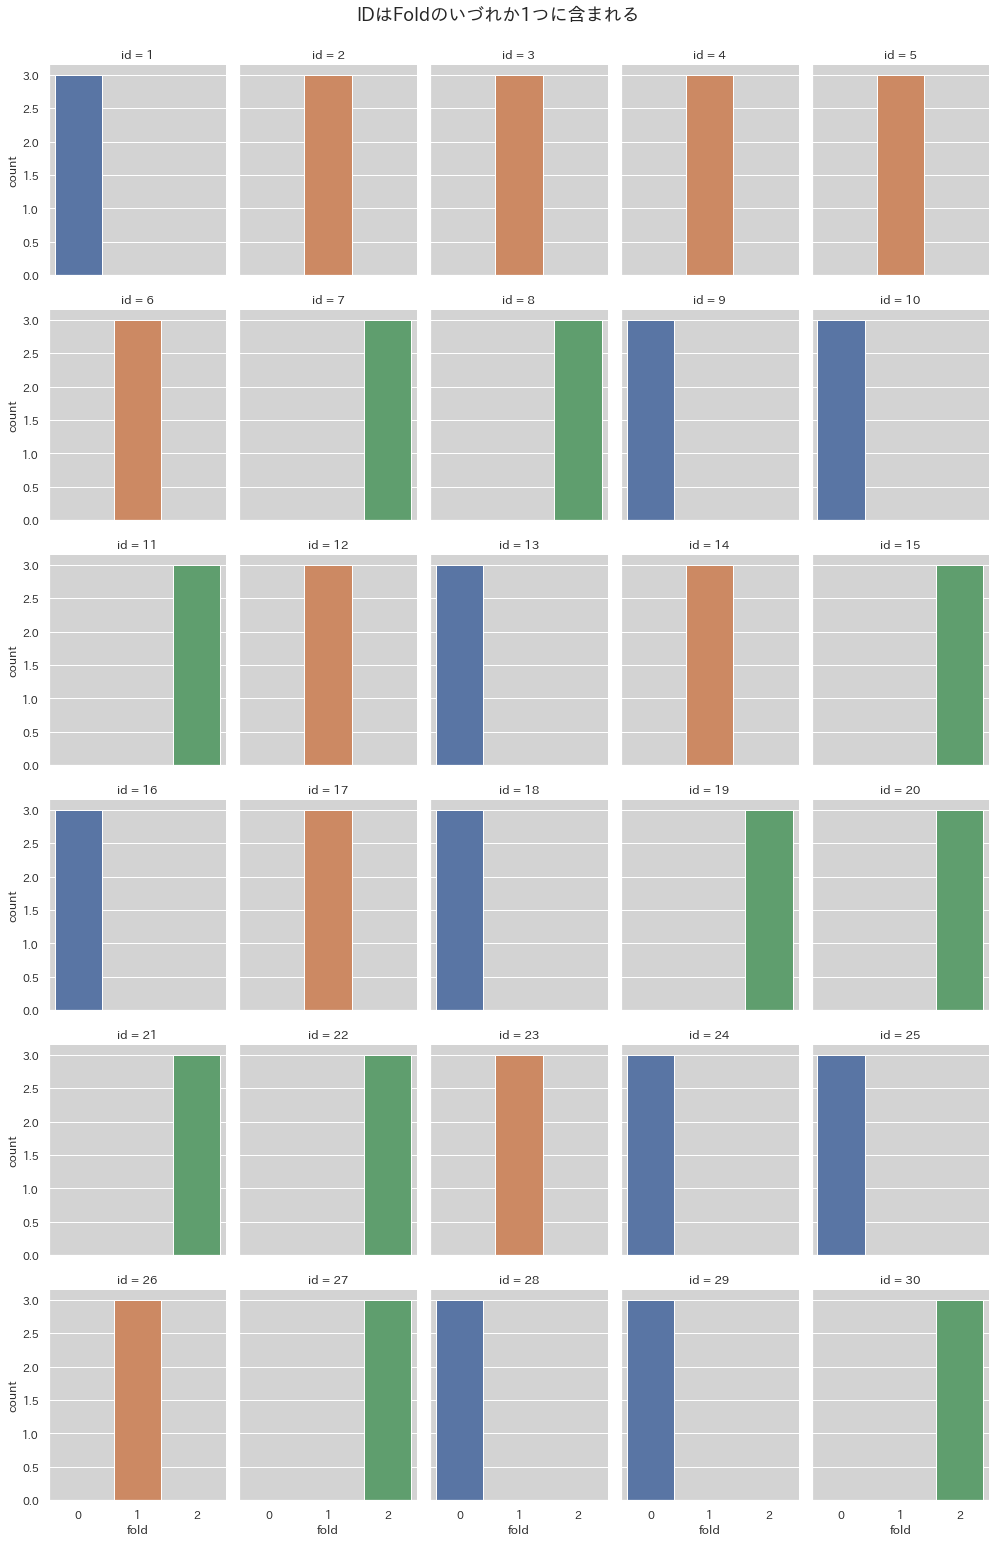

In [24]:
sns.set(rc={'axes.facecolor':'lightgrey','figure.facecolor':'white','font.family':'IPAexGothic'})
g = sns.catplot(data=data, x="fold", col="id", col_wrap=5,
                kind="count", height=3.5, aspect=.8)
# set title
g.fig.suptitle("IDはFoldのいづれか1つに含まれる", size=18, weight=2, x=.5, y=1.02)
plt.show()

## **StratifiedKFold**

In [25]:
def StratifiedKFold_def(df, target_col_name, n_splits, *,shuffle=False, random_state=None):
    df["fold"] = 99
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    for fold, (tr_idx, va_idx) in enumerate(skf.split(df, df[target_col_name])):
        df.loc[tr_idx, f"fold_{fold}"] = 0
        df.loc[va_idx, f"fold_{fold}"] = 1
        df.loc[va_idx, f"fold"] = fold
    return df

In [26]:
# データの準備
data_ = sns.load_dataset('exercise')

shuffle=False

In [27]:
split = 3
data = StratifiedKFold_def(data_, 'kind', split)

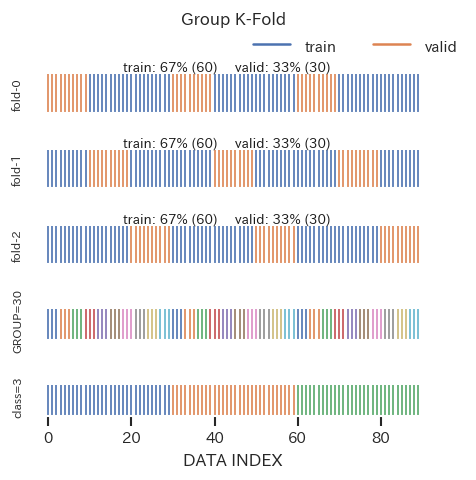

In [28]:
folds=[i for i in range(split)]

sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
nr, nc = len(folds)+2, 1
fig, axes = plt.subplots(nr, nc, figsize=(500/dpi, 100*5/dpi), dpi=dpi, tight_layout=True, facecolor="w")

for i, (fold, ax) in enumerate(zip(folds, axes)):
  if i == 0:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=True, ax=ax)

    # legend
    ## label name
    legend = g.get_legend()
    labels = [] if legend is None else [str(x._text) for x in legend.texts]
    handles = [] if legend is None else legend.legendHandles
    g.legend(handles, ["train", "valid"], title=None)
    ## move legend
    sns.move_legend(g, "lower center", bbox_to_anchor=(.8, 1.1), ncol=2, frameon=False)
    ## set font size legend
    plt.setp(g.get_legend().get_texts(), fontsize='9')
    plt.setp(g.get_legend().get_title(), fontsize='9') 
  else:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=False, ax=ax)

  # set title
  if i == 0:
    g.set_title(f'Group K-Fold', fontsize=10, pad=30)

  # tick
  g.tick_params(bottom=False, left=False, right=False, top=False,
                labelbottom=False, labelleft=False, labelright=False, labeltop=False,
                labelsize=9)
  sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

  # ylabel
  g.set_ylabel(f'fold-{fold}', fontsize=7)

  # Add text
  g.text(len(data)/2 -len(data)*0.3, 0.3, f'train: {len(data[data[f"fold_{fold}"] == 0])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 0])})', fontsize=8, color='k')
  g.text(len(data)/2 , 0.3, f'valid: {len(data[data[f"fold_{fold}"] == 1])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 1])})', fontsize=8, color='k')


# plot ID
ax = axes[-2]
g = sns.rugplot(data=data, x=data.index, hue=f"id", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.id.unique())))
## tick
g.tick_params(bottom=False, left=False, right=False, top=False,
              labelbottom=False, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
## ylabel
g.set_ylabel(f'GROUP={len(data_.id.unique())}', fontsize=7)


# plot kind
ax = axes[-1]
g = sns.rugplot(data=data, x=data.index, hue=f"kind", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.kind.unique())))
## tick
g.tick_params(bottom=True, left=False, right=False, top=False,
              labelbottom=True, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
## xlabel
g.set_xlabel("DATA INDEX", fontsize=10)
## ylabel
g.set_ylabel(f'class={len(data_.kind.unique())}', fontsize=7)

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

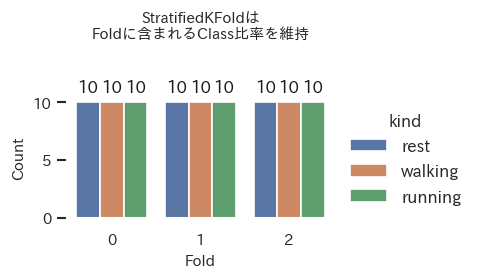

In [29]:
sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
ax = plt.subplots(figsize=(500/dpi, 300/dpi), dpi=dpi, tight_layout=True, facecolor="w")

g = sns.countplot(data=data, x="fold", hue="kind")
# set title
g.set_title(f'StratifiedKFoldは\nFoldに含まれるClass比率を維持', fontsize=9, pad=35)
## move legend
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), ncol=1, frameon=False)
## set font size legend
plt.setp(g.get_legend().get_texts(), fontsize='10')
plt.setp(g.get_legend().get_title(), fontsize='10')
## tick
g.tick_params(bottom=False, left=True, right=False, top=False,
              labelbottom=True, labelleft=True, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
# xlabel ylabel
g.set_xlabel(f'Fold', fontsize=9)
g.set_ylabel(f'Count', fontsize=9)
for p in g.patches:
  g.annotate(format(p.get_height(), '.0f'),
             (p.get_x() + p.get_width() / 2., p.get_height()), 
             ha = 'center', 
             va = 'center', 
             xytext = (0, 9), 
             textcoords = 'offset points',
             fontsize = 10,
             color = 'k')
plt.show()

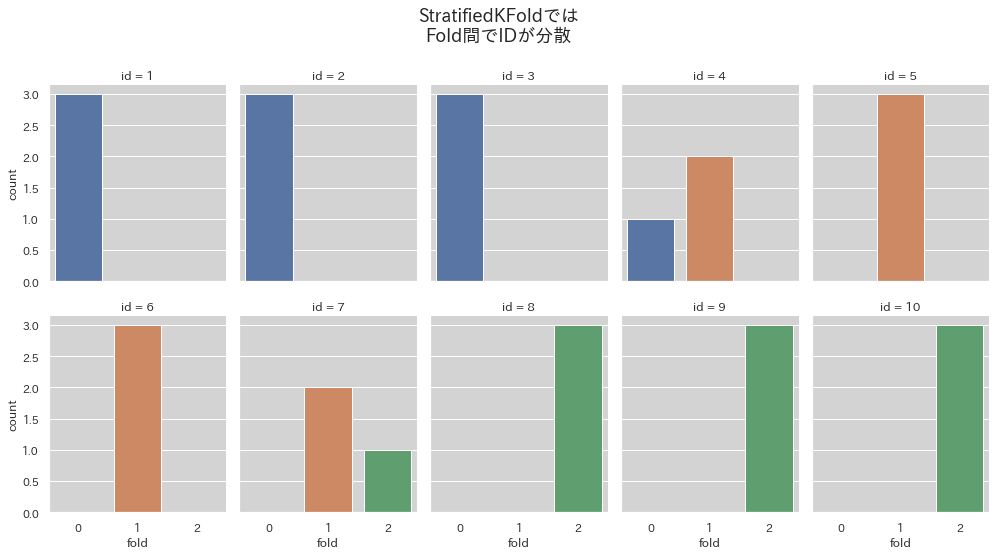

In [30]:
sns.set(rc={'axes.facecolor':'lightgrey','figure.facecolor':'white','font.family':'IPAexGothic'})

g = sns.catplot(data=data[data.id <= 10], x="fold", col="id", col_wrap=5,
                kind="count", height=3.5, aspect=.8)
# set title
g.fig.suptitle("StratifiedKFoldでは\nFold間でIDが分散", size=18, weight=2, x=.5, y=1.1)
plt.show()

shuffle=True

In [31]:
split = 3
data = StratifiedKFold_def(data_, 'kind', split, shuffle=True, random_state=random_state)

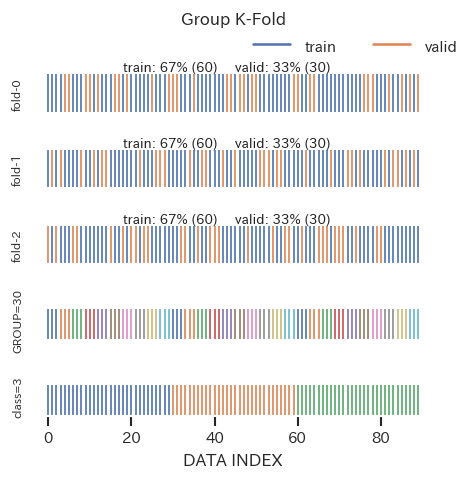

In [32]:
folds=[i for i in range(split)]

sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
nr, nc = len(folds)+2, 1
fig, axes = plt.subplots(nr, nc, figsize=(500/dpi, 100*5/dpi), dpi=dpi, tight_layout=True, facecolor="w")

for i, (fold, ax) in enumerate(zip(folds, axes)):
  if i == 0:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=True, ax=ax)

    # legend
    ## label name
    legend = g.get_legend()
    labels = [] if legend is None else [str(x._text) for x in legend.texts]
    handles = [] if legend is None else legend.legendHandles
    g.legend(handles, ["train", "valid"], title=None)
    ## move legend
    sns.move_legend(g, "lower center", bbox_to_anchor=(.8, 1.1), ncol=2, frameon=False)
    ## set font size legend
    plt.setp(g.get_legend().get_texts(), fontsize='9')
    plt.setp(g.get_legend().get_title(), fontsize='9') 
  else:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=False, ax=ax)

  # set title
  if i == 0:
    g.set_title(f'Group K-Fold', fontsize=10, pad=30)

  # tick
  g.tick_params(bottom=False, left=False, right=False, top=False,
                labelbottom=False, labelleft=False, labelright=False, labeltop=False,
                labelsize=9)
  sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

  # ylabel
  g.set_ylabel(f'fold-{fold}', fontsize=7)

  # Add text
  g.text(len(data)/2 -len(data)*0.3, 0.3, f'train: {len(data[data[f"fold_{fold}"] == 0])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 0])})', fontsize=8, color='k')
  g.text(len(data)/2 , 0.3, f'valid: {len(data[data[f"fold_{fold}"] == 1])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 1])})', fontsize=8, color='k')


# plot ID
ax = axes[-2]
g = sns.rugplot(data=data, x=data.index, hue=f"id", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.id.unique())))
## tick
g.tick_params(bottom=False, left=False, right=False, top=False,
              labelbottom=False, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
## ylabel
g.set_ylabel(f'GROUP={len(data_.id.unique())}', fontsize=7)


# plot kind
ax = axes[-1]
g = sns.rugplot(data=data, x=data.index, hue=f"kind", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.kind.unique())))
## tick
g.tick_params(bottom=True, left=False, right=False, top=False,
              labelbottom=True, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
## xlabel
g.set_xlabel("DATA INDEX", fontsize=10)
## ylabel
g.set_ylabel(f'class={len(data_.kind.unique())}', fontsize=7)

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

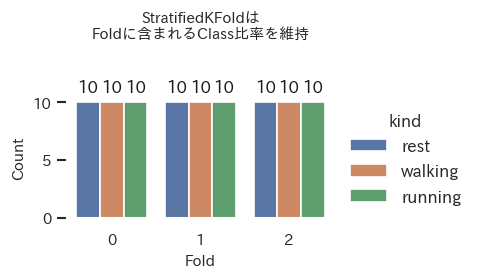

In [33]:
sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
ax = plt.subplots(figsize=(500/dpi, 300/dpi), dpi=dpi, tight_layout=True, facecolor="w")

g = sns.countplot(data=data, x="fold", hue="kind")
# set title
g.set_title(f'StratifiedKFoldは\nFoldに含まれるClass比率を維持', fontsize=9, pad=35)
## move legend
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), ncol=1, frameon=False)
## set font size legend
plt.setp(g.get_legend().get_texts(), fontsize='10')
plt.setp(g.get_legend().get_title(), fontsize='10')
## tick
g.tick_params(bottom=False, left=True, right=False, top=False,
              labelbottom=True, labelleft=True, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
# xlabel ylabel
g.set_xlabel(f'Fold', fontsize=9)
g.set_ylabel(f'Count', fontsize=9)
for p in g.patches:
  g.annotate(format(p.get_height(), '.0f'),
             (p.get_x() + p.get_width() / 2., p.get_height()), 
             ha = 'center', 
             va = 'center', 
             xytext = (0, 9), 
             textcoords = 'offset points',
             fontsize = 10,
             color = 'k')
plt.show()

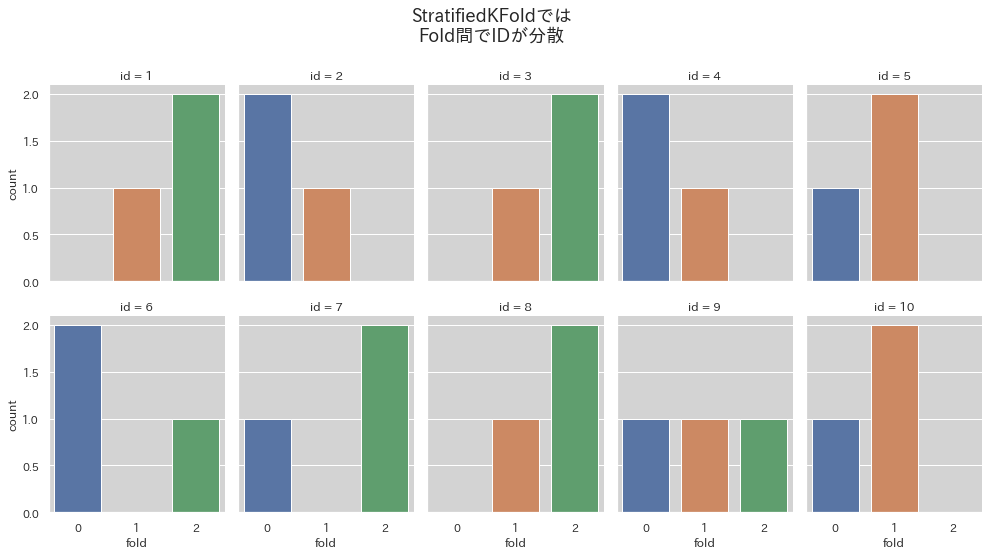

In [34]:
sns.set(rc={'axes.facecolor':'lightgrey','figure.facecolor':'white','font.family':'IPAexGothic'})
g = sns.catplot(data=data[data.id <= 10], x="fold", col="id", col_wrap=5,
                kind="count", height=3.5, aspect=.8)
# set title
g.fig.suptitle("StratifiedKFoldでは\nFold間でIDが分散", size=18, weight=2, x=.5, y=1.1)
plt.show()

## **StratifiedGroupKFold**

In [35]:
def StratifiedGroupKFold_def(df, n_splits, ID_col_name, target_col_name, *, shuffle=False, random_state=None):
    df["fold"] = 99
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    for fold, (tr_idx, va_idx) in enumerate(sgkf.split(df, df[target_col_name], df[ID_col_name])):
        df.loc[tr_idx, f"fold_{fold}"] = 0
        df.loc[va_idx, f"fold_{fold}"] = 1
        df.loc[va_idx, f"fold"] = fold
    return df

In [36]:
# データを捨ててでもオリジナルのターゲットの比率を維持する
def StratifiedGroupKFold_Ratio_def(X, y, ID_COL_NAME, groups, k, random_state=None):
    def Count_y(y, groups):
        # y counts per group
        unique_num = np.max(y) + 1
        y_counts_per_group = defaultdict(lambda: np.zeros(unique_num))
        for label, g in zip(y, groups):
            y_counts_per_group[g][label] += 1
        return y_counts_per_group
    # Preparation
    max_y = np.max(y)
    y_counts_per_group = Count_y(y, groups)
    kf = GroupKFold(n_splits=k)
    for train_idx, val_idx in kf.split(X, y, groups):
        # Training dataset and validation dataset
        x_train = X.iloc[train_idx, :]
        id_train = x_train[ID_COL_NAME].unique()
        x_val, y_val = X.iloc[val_idx, :], y.iloc[val_idx]
        id_val = x_val[ID_COL_NAME].unique()
        # y counts of training dataset and validation dataset
        y_counts_train = np.zeros(max_y+1)
        y_counts_val = np.zeros(max_y+1)
        for id_ in id_train:
            y_counts_train += y_counts_per_group[id_]
        for id_ in id_val:
            y_counts_val += y_counts_per_group[id_]
        # Determination ratio of validation dataset
        numratio_train = y_counts_train / np.max(y_counts_train)
        stratified_count = np.ceil(y_counts_val[np.argmax(y_counts_train)] * numratio_train)
        stratified_count = stratified_count.astype(int)
        # Select validation dataset randomly
        val_idx = np.array([])
        np.random.seed(random_state)
        for num in range(max_y+1):
            val_idx = np.append(val_idx, np.random.choice(y_val[y_val==num].index, stratified_count[num]))
        val_idx = val_idx.astype(int)
        val_idx = np.unique(val_idx)
        yield train_idx, val_idx
def StratifiedGroupKFold_Ratio(df, n_splits, ID_col_name, target_col_name, *, random_state=42):
    def Get_distribution(y_vals):
        # Get distribution
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f"{y_distr[i] / y_vals_sum:.2%}" for i in range(np.max(y_vals) + 1)]
    def Get_res_df(fold,tr_idx,va_idx):
        print(f"Tr_ID - fold {fold}:", df.loc[tr_idx, ID_col_name].unique(),
              f"Va_ID - fold {fold}:", df.loc[va_idx, ID_col_name].unique())
        print(f"data volume - fold {fold}: {y.shape[0]} =>>> {y[tr_idx].shape[0]+y[va_idx].shape[0]}")
        print("*"*60)
        distrs.append(Get_distribution(y[tr_idx]));res_title.append(f"Tr set - fold {fold}");
        distrs.append(Get_distribution(y[va_idx]));res_title.append(f"Va set - fold {fold}");
        return distrs, res_title
    X = df.drop([target_col_name], axis=1, inplace=False)
    y = df[target_col_name] # multi-labels target (0～)
    _ids = df[ID_col_name]
    res_title = ["Original dataset"]
    distrs = [Get_distribution(y)]
    for fold, (tr_idx, va_idx) in enumerate(StratifiedGroupKFold_Ratio_def(X, y, ID_col_name, _ids, n_splits, random_state)):
        distrs, res_title = Get_res_df(fold, tr_idx, va_idx)
        df.loc[tr_idx, f"fold_{fold}"] = 0
        df.loc[va_idx, f"fold_{fold}"] = 1
        df.loc[va_idx, f"fold"] = fold
    res_df = pd.DataFrame(distrs, index=res_title, columns=[f"Label {l}" for l in range(np.max(y) + 1)])
    return df, res_df

In [37]:
# オリジナルのターゲットの比率を多少犠牲にしてでもデータ量を維持する
def StratifiedGroupKFold_Volume_def(X, y, groups, k, seed=None):  
    labels_num = np.max(y) + 1  
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))  
    y_distr = Counter()  
    for label, g in zip(y, groups):  
        y_counts_per_group[g][label] += 1  
        y_distr[label] += 1  
    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))  
    groups_per_fold = defaultdict(set)  
    def eval_y_counts_per_fold(y_counts, fold):  
        y_counts_per_fold[fold] += y_counts  
        std_per_label = []  
        for label in range(labels_num):  
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])  
            std_per_label.append(label_std)  
        y_counts_per_fold[fold] -= y_counts  
        return np.mean(std_per_label)  
    groups_and_y_counts = list(y_counts_per_group.items())  
    random.Random(seed).shuffle(groups_and_y_counts)  
    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):  
        best_fold = None  
        min_eval = None  
        for i in range(k):  
            fold_eval = eval_y_counts_per_fold(y_counts, i)  
            if min_eval is None or fold_eval < min_eval:  
                min_eval = fold_eval  
                best_fold = i  
        y_counts_per_fold[best_fold] += y_counts  
        groups_per_fold[best_fold].add(g)  
    all_groups = set(groups)  
    for i in range(k):  
        train_groups = all_groups - groups_per_fold[i]  
        test_groups = groups_per_fold[i]  
        train_indices = [i for i, g in enumerate(groups) if g in train_groups]  
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]  
        yield train_indices, test_indices 
def StratifiedGroupKFold_Volume(df, n_splits, ID_col_name, target_col_name, *, random_state=42):  
    def Get_distribution(y_vals):   
        # Get distribution   
        y_distr = Counter(y_vals)   
        y_vals_sum = sum(y_distr.values())   
        return [f"{y_distr[i] / y_vals_sum:.2%}" for i in range(np.max(y_vals) + 1)]   
    def Get_res_df(fold,tr_idx,va_idx):   
        print(f"Tr_ID - fold {fold}:", df.loc[tr_idx, ID_col_name].unique(),  
              f"Va_ID - fold {fold}:", df.loc[va_idx, ID_col_name].unique())   
        print(f"data volume - fold {fold}: {y.shape[0]} =>>> {y[tr_idx].shape[0]+y[va_idx].shape[0]}")   
        print("*"*60)   
        distrs.append(Get_distribution(y[tr_idx]));res_title.append(f"Tr set - fold {fold}");   
        distrs.append(Get_distribution(y[va_idx]));res_title.append(f"Va set - fold {fold}");   
        return distrs, res_title  
    X = df.drop([target_col_name], axis=1, inplace=False)    
    y = df[target_col_name] # multi-labels target (0～)   
    _ids = df[ID_col_name]   
    res_title = ["Original dataset"] 
    distrs = [Get_distribution(y)] 
    for fold, (tr_idx, va_idx) in enumerate(StratifiedGroupKFold_Volume_def(X, y, _ids, n_splits, random_state)):  
        distrs, res_title = Get_res_df(fold, tr_idx, va_idx)  
        df.loc[tr_idx, f"fold_{fold}"] = 0  
        df.loc[va_idx, f"fold_{fold}"] = 1
        df.loc[va_idx, f"fold"] = fold
    res_df = pd.DataFrame(distrs, index=res_title, columns=[f"Label {l}" for l in range(np.max(y) + 1)])  
    return df, res_df

### StratifiedGroupKFold(sklearn)

In [38]:
# データの準備
data_ = sns.load_dataset('exercise')
# taeget を LabelEncoder
le = LabelEncoder()
le.fit(data_['kind'])
data_['kind'] = le.transform(data_['kind'])

In [39]:
splits = 4
data = StratifiedGroupKFold_def(data_, splits, 'id', 'kind')

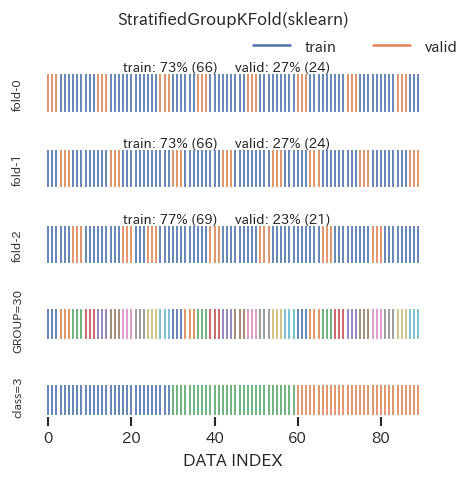

In [40]:
folds=[i for i in range(split)]

sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
nr, nc = len(folds)+2, 1
fig, axes = plt.subplots(nr, nc, figsize=(500/dpi, 100*5/dpi), dpi=dpi, tight_layout=True, facecolor="w")

for i, (fold, ax) in enumerate(zip(folds, axes)):
  if i == 0:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=True, ax=ax)

    # legend
    ## label name
    legend = g.get_legend()
    labels = [] if legend is None else [str(x._text) for x in legend.texts]
    handles = [] if legend is None else legend.legendHandles
    g.legend(handles, ["train", "valid"], title=None)
    ## move legend
    sns.move_legend(g, "lower center", bbox_to_anchor=(.8, 1.1), ncol=2, frameon=False)
    ## set font size legend
    plt.setp(g.get_legend().get_texts(), fontsize='9')
    plt.setp(g.get_legend().get_title(), fontsize='9') 
  else:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=False, ax=ax)

  # set title
  if i == 0:
    g.set_title(f'StratifiedGroupKFold(sklearn)', fontsize=10, pad=30)

  # tick
  g.tick_params(bottom=False, left=False, right=False, top=False,
                labelbottom=False, labelleft=False, labelright=False, labeltop=False,
                labelsize=9)
  sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

  # ylabel
  g.set_ylabel(f'fold-{fold}', fontsize=7)

  # Add text
  g.text(len(data)/2 -len(data)*0.3, 0.3, f'train: {len(data[data[f"fold_{fold}"] == 0])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 0])})', fontsize=8, color='k')
  g.text(len(data)/2 , 0.3, f'valid: {len(data[data[f"fold_{fold}"] == 1])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 1])})', fontsize=8, color='k')


# plot ID
ax = axes[-2]
g = sns.rugplot(data=data, x=data.index, hue=f"id", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.id.unique())))
## tick
g.tick_params(bottom=False, left=False, right=False, top=False,
              labelbottom=False, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
## ylabel
g.set_ylabel(f'GROUP={len(data_.id.unique())}', fontsize=7)


# plot kind
ax = axes[-1]
g = sns.rugplot(data=data, x=data.index, hue=f"kind", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.kind.unique())))
## tick
g.tick_params(bottom=True, left=False, right=False, top=False,
              labelbottom=True, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
## xlabel
g.set_xlabel("DATA INDEX", fontsize=10)
## ylabel
g.set_ylabel(f'class={len(data_.kind.unique())}', fontsize=7)

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

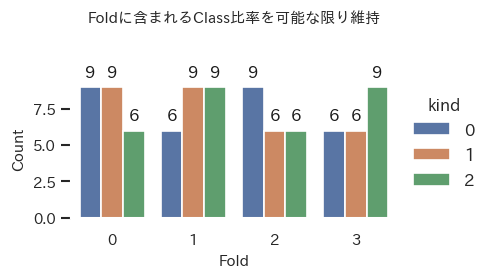

In [41]:
sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
ax = plt.subplots(figsize=(500/dpi, 300/dpi), dpi=dpi, tight_layout=True, facecolor="w")

g = sns.countplot(data=data, x="fold", hue="kind")
# set title
g.set_title(f'Foldに含まれるClass比率を可能な限り維持', fontsize=9, pad=35)
## move legend
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), ncol=1, frameon=False)
## set font size legend
plt.setp(g.get_legend().get_texts(), fontsize='10')
plt.setp(g.get_legend().get_title(), fontsize='10')
## tick
g.tick_params(bottom=False, left=True, right=False, top=False,
              labelbottom=True, labelleft=True, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
# xlabel ylabel
g.set_xlabel(f'Fold', fontsize=9)
g.set_ylabel(f'Count', fontsize=9)
for p in g.patches:
  g.annotate(format(p.get_height(), '.0f'),
             (p.get_x() + p.get_width() / 2., p.get_height()), 
             ha = 'center', 
             va = 'center', 
             xytext = (0, 9), 
             textcoords = 'offset points',
             fontsize = 10,
             color = 'k')
plt.show()

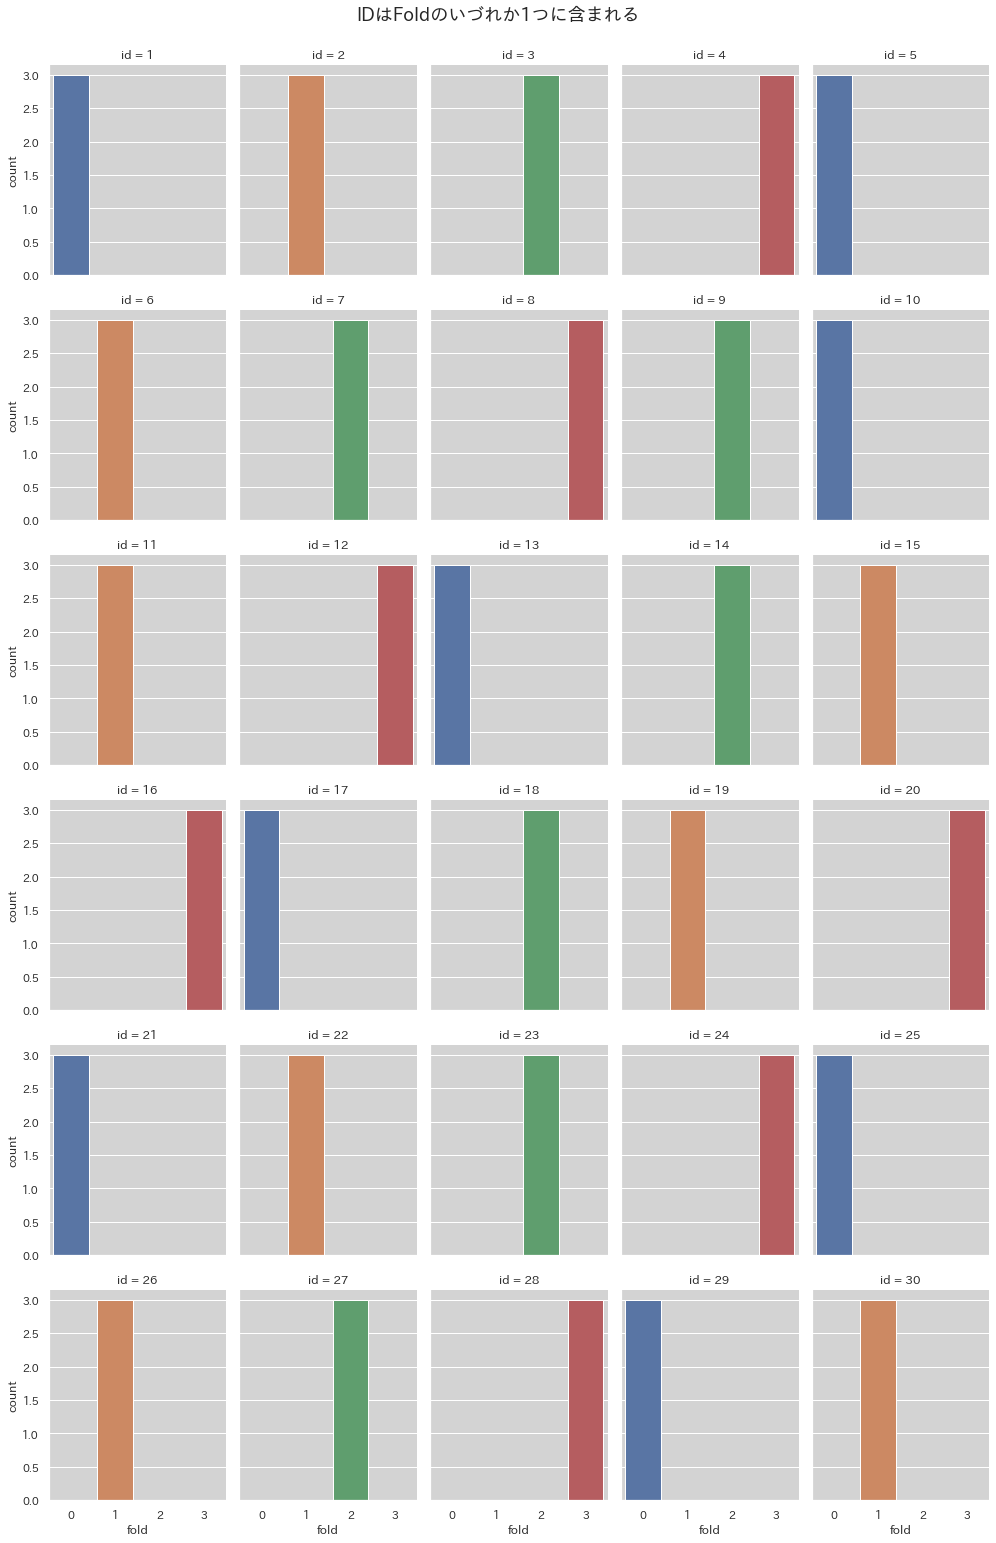

In [42]:
sns.set(rc={'axes.facecolor':'lightgrey','figure.facecolor':'white','font.family':'IPAexGothic'})
g = sns.catplot(data=data, x="fold", col="id", col_wrap=5,
                kind="count", height=3.5, aspect=.8)
# set title
g.fig.suptitle("IDはFoldのいづれか1つに含まれる", size=18, weight=2, x=.5, y=1.02)
plt.show()

### StratifiedGroupKFold_Ratio  
データを捨ててでもオリジナルのターゲットの比率を維持する

In [43]:
# データの準備
data_ = sns.load_dataset('exercise')
# taeget を LabelEncoder
le = LabelEncoder()
le.fit(data_['kind'])
data_['kind'] = le.transform(data_['kind'])

In [44]:
splits = 4
data, res_df = StratifiedGroupKFold_Ratio(data_, splits, 'id', 'kind', random_state=random_state)

Tr_ID - fold 0: [ 1  2  3  5  6  7  9 10 11 13 14 15 17 18 19 21 22 23 25 26 27 29] Va_ID - fold 0: [ 4  8 12 16 20 24 28 30]
data volume - fold 0: 90 =>>> 80
************************************************************
Tr_ID - fold 1: [ 2  3  4  6  7  8 10 11 12 14 15 16 18 19 20 22 23 24 26 27 28 30] Va_ID - fold 1: [ 1  5  9 13 17 25 29]
data volume - fold 1: 90 =>>> 80
************************************************************
Tr_ID - fold 2: [ 1  3  4  5  7  8  9 11 12 13 15 16 17 19 20 21 23 24 25 27 28 29 30] Va_ID - fold 2: [ 2  6 10 14 18 22 26]
data volume - fold 2: 90 =>>> 82
************************************************************
Tr_ID - fold 3: [ 1  2  4  5  6  8  9 10 12 13 14 16 17 18 20 21 22 24 25 26 28 29 30] Va_ID - fold 3: [ 3  7 11 15 19 23 27]
data volume - fold 3: 90 =>>> 80
************************************************************


In [45]:
res_df

,Label 0,Label 1,Label 2
Original dataset,33.33%,33.33%,33.33%
Tr set - fold 0,36.36%,31.82%,31.82%
Va set - fold 0,28.57%,35.71%,35.71%
Tr set - fold 1,31.82%,31.82%,36.36%
Va set - fold 1,35.71%,28.57%,35.71%
Tr set - fold 2,30.43%,34.78%,34.78%
Va set - fold 2,38.46%,30.77%,30.77%
Tr set - fold 3,34.78%,34.78%,30.43%
Va set - fold 3,36.36%,27.27%,36.36%


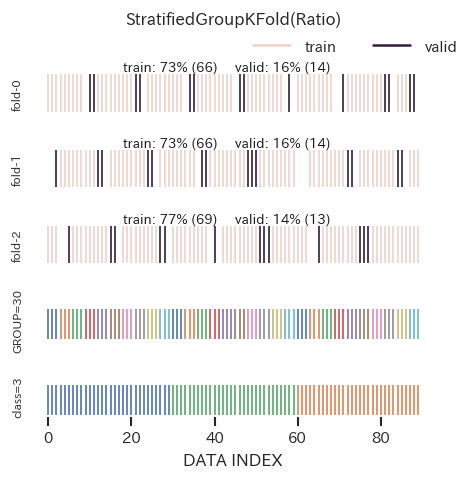

In [46]:
folds=[i for i in range(split)]

sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
nr, nc = len(folds)+2, 1
fig, axes = plt.subplots(nr, nc, figsize=(500/dpi, 100*5/dpi), dpi=dpi, tight_layout=True, facecolor="w")

for i, (fold, ax) in enumerate(zip(folds, axes)):
  if i == 0:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=True, ax=ax)

    # legend
    ## label name
    legend = g.get_legend()
    labels = [] if legend is None else [str(x._text) for x in legend.texts]
    handles = [] if legend is None else legend.legendHandles
    g.legend(handles, ["train", "valid"], title=None)
    ## move legend
    sns.move_legend(g, "lower center", bbox_to_anchor=(.8, 1.1), ncol=2, frameon=False)
    ## set font size legend
    plt.setp(g.get_legend().get_texts(), fontsize='9')
    plt.setp(g.get_legend().get_title(), fontsize='9') 
  else:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=False, ax=ax)

  # set title
  if i == 0:
    g.set_title(f'StratifiedGroupKFold(Ratio)', fontsize=10, pad=30)

  # tick
  g.tick_params(bottom=False, left=False, right=False, top=False,
                labelbottom=False, labelleft=False, labelright=False, labeltop=False,
                labelsize=9)
  sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

  # ylabel
  g.set_ylabel(f'fold-{fold}', fontsize=7)

  # Add text
  g.text(len(data)/2 -len(data)*0.3, 0.3, f'train: {len(data[data[f"fold_{fold}"] == 0])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 0])})', fontsize=8, color='k')
  g.text(len(data)/2 , 0.3, f'valid: {len(data[data[f"fold_{fold}"] == 1])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 1])})', fontsize=8, color='k')


# plot ID
ax = axes[-2]
g = sns.rugplot(data=data, x=data.index, hue=f"id", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.id.unique())))
## tick
g.tick_params(bottom=False, left=False, right=False, top=False,
              labelbottom=False, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
## ylabel
g.set_ylabel(f'GROUP={len(data_.id.unique())}', fontsize=7)


# plot kind
ax = axes[-1]
g = sns.rugplot(data=data, x=data.index, hue=f"kind", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.kind.unique())))
## tick
g.tick_params(bottom=True, left=False, right=False, top=False,
              labelbottom=True, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
## xlabel
g.set_xlabel("DATA INDEX", fontsize=10)
## ylabel
g.set_ylabel(f'class={len(data_.kind.unique())}', fontsize=7)

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

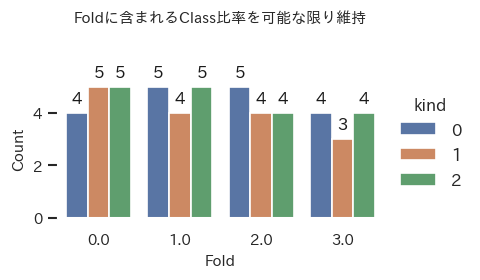

In [47]:
sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
ax = plt.subplots(figsize=(500/dpi, 300/dpi), dpi=dpi, tight_layout=True, facecolor="w")

g = sns.countplot(data=data, x="fold", hue="kind")
# set title
g.set_title(f'Foldに含まれるClass比率を可能な限り維持', fontsize=9, pad=35)
## move legend
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), ncol=1, frameon=False)
## set font size legend
plt.setp(g.get_legend().get_texts(), fontsize='10')
plt.setp(g.get_legend().get_title(), fontsize='10')
## tick
g.tick_params(bottom=False, left=True, right=False, top=False,
              labelbottom=True, labelleft=True, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
# xlabel ylabel
g.set_xlabel(f'Fold', fontsize=9)
g.set_ylabel(f'Count', fontsize=9)
for p in g.patches:
  g.annotate(format(p.get_height(), '.0f'),
             (p.get_x() + p.get_width() / 2., p.get_height()), 
             ha = 'center', 
             va = 'center', 
             xytext = (0, 9),
             textcoords = 'offset points',
             fontsize = 10,
             color = 'k')
plt.show()

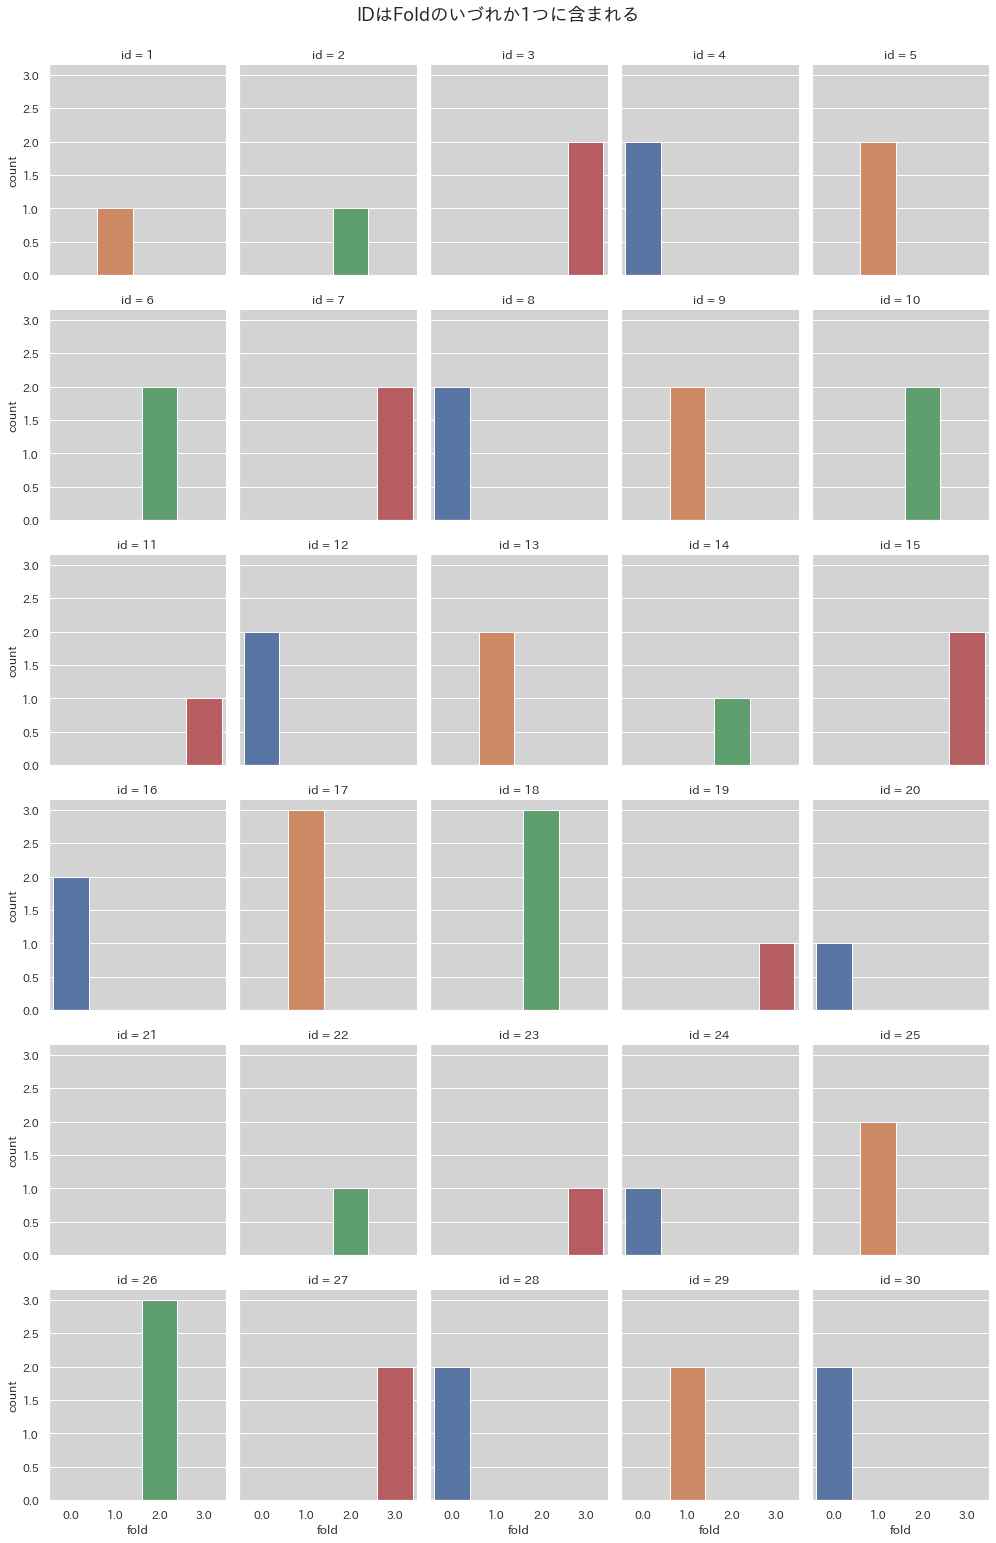

In [48]:
sns.set(rc={'axes.facecolor':'lightgrey','figure.facecolor':'white','font.family':'IPAexGothic'})
g = sns.catplot(data=data, x="fold", col="id", col_wrap=5,
                kind="count", height=3.5, aspect=.8)
# set title
g.fig.suptitle("IDはFoldのいづれか1つに含まれる", size=18, weight=2, x=.5, y=1.02)
plt.show()

### StratifiedGroupKFold_Volume  
オリジナルのターゲットの比率を多少犠牲にしてでもデータ量を維持する

In [49]:
# データの準備
data_ = sns.load_dataset('exercise')
# taeget を LabelEncoder
le = LabelEncoder()
le.fit(data_['kind'])
data_['kind'] = le.transform(data_['kind'])

In [50]:
splits = 4
data, res_df = StratifiedGroupKFold_Volume(data_, splits, 'id', 'kind', random_state=random_state)

Tr_ID - fold 0: [ 2  4  5  6  8  9 10 11 13 14 15 16 17 19 21 23 25 26 28 29 30] Va_ID - fold 0: [ 1  3  7 12 18 20 22 24 27]
data volume - fold 0: 90 =>>> 90
************************************************************
Tr_ID - fold 1: [ 1  2  3  7  8  9 10 11 12 13 14 17 18 19 20 22 24 25 26 27 29 30] Va_ID - fold 1: [ 4  5  6 15 16 21 23 28]
data volume - fold 1: 90 =>>> 90
************************************************************
Tr_ID - fold 2: [ 1  2  3  4  5  6  7  9 12 13 14 15 16 18 20 21 22 23 24 25 27 28 30] Va_ID - fold 2: [ 8 10 11 17 19 26 29]
data volume - fold 2: 90 =>>> 90
************************************************************
Tr_ID - fold 3: [ 1  3  4  5  6  7  8 10 11 12 15 16 17 18 19 20 21 22 23 24 26 27 28 29] Va_ID - fold 3: [ 2  9 13 14 25 30]
data volume - fold 3: 90 =>>> 90
************************************************************


In [51]:
res_df

,Label 0,Label 1,Label 2
Original dataset,33.33%,33.33%,33.33%
Tr set - fold 0,33.33%,33.33%,33.33%
Va set - fold 0,33.33%,33.33%,33.33%
Tr set - fold 1,31.82%,31.82%,36.36%
Va set - fold 1,37.50%,37.50%,25.00%
Tr set - fold 2,34.78%,34.78%,30.43%
Va set - fold 2,28.57%,28.57%,42.86%
Tr set - fold 3,33.33%,33.33%,33.33%
Va set - fold 3,33.33%,33.33%,33.33%


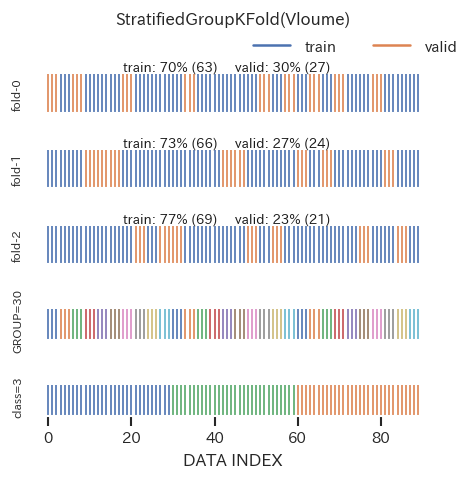

In [52]:
folds=[i for i in range(split)]

sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
nr, nc = len(folds)+2, 1
fig, axes = plt.subplots(nr, nc, figsize=(500/dpi, 100*5/dpi), dpi=dpi, tight_layout=True, facecolor="w")

for i, (fold, ax) in enumerate(zip(folds, axes)):
  if i == 0:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=True, ax=ax)

    # legend
    ## label name
    legend = g.get_legend()
    labels = [] if legend is None else [str(x._text) for x in legend.texts]
    handles = [] if legend is None else legend.legendHandles
    g.legend(handles, ["train", "valid"], title=None)
    ## move legend
    sns.move_legend(g, "lower center", bbox_to_anchor=(.8, 1.1), ncol=2, frameon=False)
    ## set font size legend
    plt.setp(g.get_legend().get_texts(), fontsize='9')
    plt.setp(g.get_legend().get_title(), fontsize='9') 
  else:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=False, ax=ax)

  # set title
  if i == 0:
    g.set_title(f'StratifiedGroupKFold(Vloume)', fontsize=10, pad=30)

  # tick
  g.tick_params(bottom=False, left=False, right=False, top=False,
                labelbottom=False, labelleft=False, labelright=False, labeltop=False,
                labelsize=9)
  sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

  # ylabel
  g.set_ylabel(f'fold-{fold}', fontsize=7)

  # Add text
  g.text(len(data)/2 -len(data)*0.3, 0.3, f'train: {len(data[data[f"fold_{fold}"] == 0])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 0])})', fontsize=8, color='k')
  g.text(len(data)/2 , 0.3, f'valid: {len(data[data[f"fold_{fold}"] == 1])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 1])})', fontsize=8, color='k')


# plot ID
ax = axes[-2]
g = sns.rugplot(data=data, x=data.index, hue=f"id", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.id.unique())))
## tick
g.tick_params(bottom=False, left=False, right=False, top=False,
              labelbottom=False, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
## ylabel
g.set_ylabel(f'GROUP={len(data_.id.unique())}', fontsize=7)


# plot kind
ax = axes[-1]
g = sns.rugplot(data=data, x=data.index, hue=f"kind", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.kind.unique())))
## tick
g.tick_params(bottom=True, left=False, right=False, top=False,
              labelbottom=True, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
## xlabel
g.set_xlabel("DATA INDEX", fontsize=10)
## ylabel
g.set_ylabel(f'class={len(data_.kind.unique())}', fontsize=7)

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

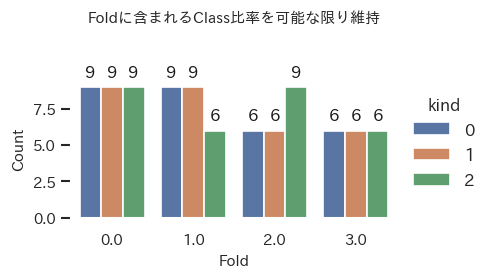

In [53]:
sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
ax = plt.subplots(figsize=(500/dpi, 300/dpi), dpi=dpi, tight_layout=True, facecolor="w")

g = sns.countplot(data=data, x="fold", hue="kind")
# set title
g.set_title(f'Foldに含まれるClass比率を可能な限り維持', fontsize=9, pad=35)
## move legend
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), ncol=1, frameon=False)
## set font size legend
plt.setp(g.get_legend().get_texts(), fontsize='10')
plt.setp(g.get_legend().get_title(), fontsize='10')
## tick
g.tick_params(bottom=False, left=True, right=False, top=False,
              labelbottom=True, labelleft=True, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
# xlabel ylabel
g.set_xlabel(f'Fold', fontsize=9)
g.set_ylabel(f'Count', fontsize=9)
for p in g.patches:
  g.annotate(format(p.get_height(), '.0f'),
             (p.get_x() + p.get_width() / 2., p.get_height()), 
             ha = 'center', 
             va = 'center', 
             xytext = (0, 9), 
             textcoords = 'offset points',
             fontsize = 10,
             color = 'k')
plt.show()

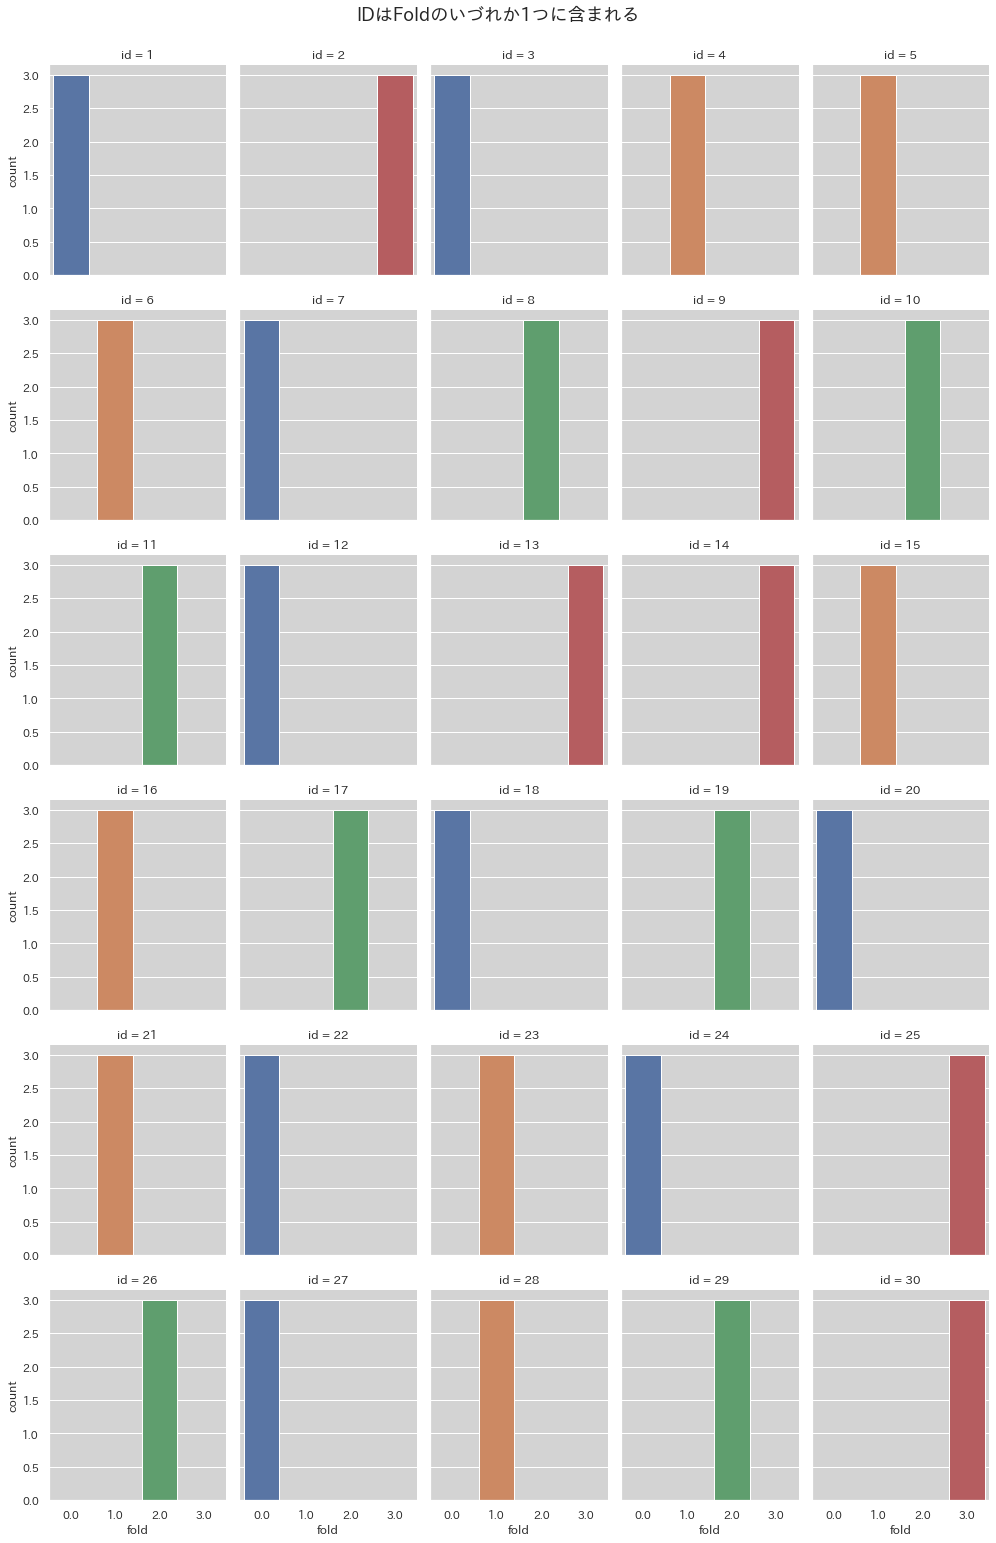

In [54]:
sns.set(rc={'axes.facecolor':'lightgrey','figure.facecolor':'white','font.family':'IPAexGothic'})
g = sns.catplot(data=data, x="fold", col="id", col_wrap=5,
                kind="count", height=3.5, aspect=.8)
# set title
g.fig.suptitle("IDはFoldのいづれか1つに含まれる", size=18, weight=2, x=.5, y=1.02)
plt.show()

## **Multilabel**

### MultilabelStratifiedKFold

In [55]:
def MultilabelStratifiedKFold_def(df, target_col_name, n_splits, *,random_state=None):
    mskf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    df["fold"] = 99
    X=df.copy()
    y=df[target_col_name]
    for fold, (tr_idx, va_idx) in enumerate(mskf.split(X, y)):
        df.loc[tr_idx, f"fold_{fold}"] = 0
        df.loc[va_idx, f"fold_{fold}"] = 1
        df.loc[va_idx, f"fold"] = fold
    return df

In [56]:
# データの準備
data_ = sns.load_dataset('exercise')
# 無理やりデータを拡張
for i in range(10):
  data_ = pd.concat([data_,data_], axis=0, ignore_index=True)
data_.sort_values('id', inplace=True)
data_.reset_index(inplace=True, drop=True)
# taeget を LabelEncoder
le = LabelEncoder()
le.fit(data_['kind'])
data_['kind'] = le.transform(data_['kind'])
data_['kind_2'] = np.array( [i for i in random.choices(list(data_.kind.unique()), k=len(data_))] )

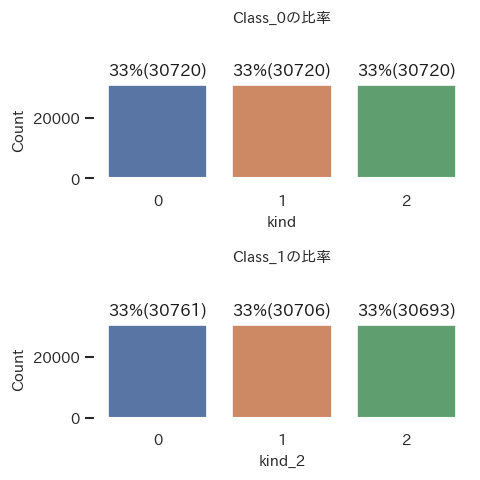

In [57]:
sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

nr, nc = 2, 1
fig, axes = plt.subplots(nr, nc, figsize=(500/dpi, 100*5/dpi), dpi=dpi, tight_layout=True, facecolor="w")

for i, (col, ax) in enumerate(zip(['kind', 'kind_2'], axes)):
  g = sns.countplot(data=data_, x=col, ax=ax)
  # set title
  g.set_title(f'Class_{i}の比率', fontsize=9, pad=35)

  ## tick
  g.tick_params(bottom=False, left=True, right=False, top=False,
                labelbottom=True, labelleft=True, labelright=False, labeltop=False,
                labelsize=9)
  sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
  # xlabel ylabel
  g.set_xlabel(f'{col}', fontsize=9)
  g.set_ylabel(f'Count', fontsize=9)
  for p in g.patches:
    g.annotate(f'{(p.get_height()/len(data_))*100:.0f}%({p.get_height():.0f})',
              (p.get_x() + p.get_width() / 2., p.get_height()), 
              ha = 'center', 
              va = 'center', 
              xytext = (0, 9), 
              textcoords = 'offset points',
              fontsize = 10,
              color = 'k')
plt.show()

In [58]:
split=3
data = MultilabelStratifiedKFold_def(data_, ['kind', 'kind_2'], split, random_state=random_state)

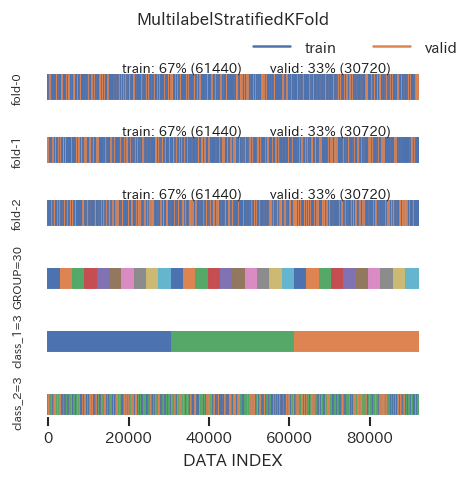

In [59]:
folds=[i for i in range(split)]

sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
nr, nc = len(folds)+3, 1
fig, axes = plt.subplots(nr, nc, figsize=(500/dpi, 100*5/dpi), dpi=dpi, tight_layout=True, facecolor="w")

for i, (fold, ax) in enumerate(zip(folds, axes)):
  if i == 0:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=True, ax=ax)

    # legend
    ## label name
    legend = g.get_legend()
    labels = [] if legend is None else [str(x._text) for x in legend.texts]
    handles = [] if legend is None else legend.legendHandles
    g.legend(handles, ["train", "valid"], title=None)
    ## move legend
    sns.move_legend(g, "lower center", bbox_to_anchor=(.8, 1.1), ncol=2, frameon=False)
    ## set font size legend
    plt.setp(g.get_legend().get_texts(), fontsize='9')
    plt.setp(g.get_legend().get_title(), fontsize='9') 
  else:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=False, ax=ax)

  # set title
  if i == 0:
    g.set_title(f'MultilabelStratifiedKFold', fontsize=10, pad=30)

  # tick
  g.tick_params(bottom=False, left=False, right=False, top=False,
                labelbottom=False, labelleft=False, labelright=False, labeltop=False,
                labelsize=9)
  sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

  # ylabel
  g.set_ylabel(f'fold-{fold}', fontsize=7)

  # Add text
  g.text(len(data)/2 -len(data)*0.3, 0.3, f'train: {len(data[data[f"fold_{fold}"] == 0])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 0])})', fontsize=8, color='k')
  g.text(len(data)/2+len(data)*0.1 , 0.3, f'valid: {len(data[data[f"fold_{fold}"] == 1])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 1])})', fontsize=8, color='k')


# plot ID
ax = axes[-3]
g = sns.rugplot(data=data, x=data.index, hue=f"id", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.id.unique())))
## tick
g.tick_params(bottom=False, left=False, right=False, top=False,
              labelbottom=False, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
## ylabel
g.set_ylabel(f'GROUP={len(data_.id.unique())}', fontsize=7)


# plot kind
ax = axes[-2]
g = sns.rugplot(data=data, x=data.index, hue=f"kind", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.kind.unique())))
## tick
g.tick_params(bottom=False, left=False, right=False, top=False,
              labelbottom=False, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
## ylabel
g.set_ylabel(f'class_1={len(data_.kind.unique())}', fontsize=7)

# plot kind_2
ax = axes[-1]
g = sns.rugplot(data=data, x=data.index, hue=f"kind_2", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.kind.unique())))
## tick
g.tick_params(bottom=True, left=False, right=False, top=False,
              labelbottom=True, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
## xlabel
g.set_xlabel("DATA INDEX", fontsize=10)
## ylabel
g.set_ylabel(f'class_2={len(data_.kind.unique())}', fontsize=7)

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

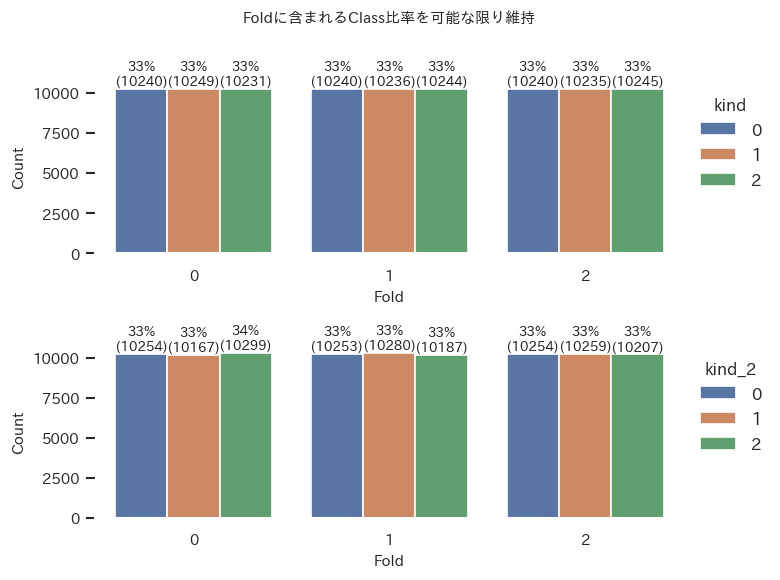

In [60]:
sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

nr, nc = 2, 1
fig, axes = plt.subplots(nr, nc, figsize=(800/dpi, 300*2/dpi), dpi=dpi, tight_layout=True, facecolor="w")

for i, (col, ax) in enumerate(zip(['kind', 'kind_2'], axes)):
  g = sns.countplot(data=data, x="fold", hue=col, ax=ax)
  if i == 0:
    # set title
    g.set_title(f'Foldに含まれるClass比率を可能な限り維持', fontsize=9, pad=35)
  ## move legend
  sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), ncol=1, frameon=False)
  ## set font size legend
  plt.setp(g.get_legend().get_texts(), fontsize='10')
  plt.setp(g.get_legend().get_title(), fontsize='10')
  ## tick
  g.tick_params(bottom=False, left=True, right=False, top=False,
                labelbottom=True, labelleft=True, labelright=False, labeltop=False,
                labelsize=9)
  sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
  # xlabel ylabel
  g.set_xlabel(f'Fold', fontsize=9)
  g.set_ylabel(f'Count', fontsize=9)
  j=0
  for p in g.patches:
    g.annotate(f'{(p.get_height()/len(data[data[f"fold_{j}"] == 1]))*100:.0f}%\n({p.get_height():.0f})',
              (p.get_x() + p.get_width() / 2., p.get_height()),
              ha = 'center',
              va = 'center',
              xytext = (0, 9),
              textcoords = 'offset points',
              fontsize = 8,
              color = 'k')
    j += 1
    if j >= split:
      j = 0
plt.show()

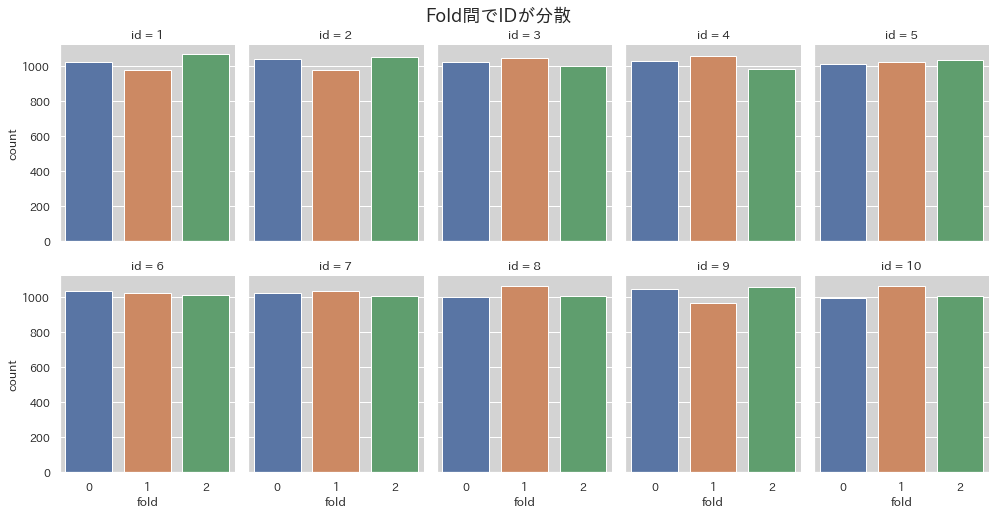

In [61]:
sns.set(rc={'axes.facecolor':'lightgrey','figure.facecolor':'white','font.family':'IPAexGothic'})
g = sns.catplot(data=data[data.id <= 10], x="fold", col="id", col_wrap=5,
                kind="count", height=3.5, aspect=.8)
# set title
g.fig.suptitle("Fold間でIDが分散", size=18, weight=2, x=.5, y=1.02)
plt.show()

### MultilabelStratifiedGroupKFold

In [62]:
def MultilabelStratifiedGroupKFold_def(df, ID_col_name, target_col_name, FOLDS, *,threshold=10, random_state=None):
    df["_ID"] = range(df.shape[0])
    # IDの含有がthreshold以下のIDは一意にGroupKFoldする（Multilabelは平均で分割）
    # → thresholdを最大値に設定するとMultilabelの平均を見て、IDに一意なfoldを設定する(真の意味でMultilabelStratifiedGroupKFold)
    # IDの含有がthreshold以上のIDはMultilabelStratifiedKFoldする
    vc = df[ID_col_name].value_counts()
    vc1 = vc.loc[vc<=threshold].index.sort_values()
    vc2 = vc.loc[vc>threshold].index.sort_values()
    dct1 = {}; dct2 = {};
    # STRATIFY DRUGS 19X OR LESS
    skf = MultilabelStratifiedKFold(n_splits=FOLDS, shuffle=True,
                                    random_state=random_state)
    tmp = df.groupby(ID_col_name)[target_col_name].mean().loc[vc1]
    for fold, (idxT,idxV) in enumerate(skf.split(tmp, tmp[target_col_name])):
        dd = {k:fold for k in tmp.index[idxV].values}
        dct1.update(dd)
    if not len(vc2)==0:
        # STRATIFY DRUGS MORE THAN 19X
        skf = MultilabelStratifiedKFold(n_splits=FOLDS, shuffle=True,
                                        random_state=random_state)
        tmp = df.loc[df[ID_col_name].isin(vc2)].reset_index(drop=True)
        for fold, (idxT,idxV) in enumerate(skf.split(tmp, tmp[target_col_name])):
            dd = {k:fold for k in tmp._ID[idxV].values}
            dct2.update(dd)
    # # ASSIGN FOLDS
    df['fold'] = df[ID_col_name].map(dct1)
    df.loc[df.fold.isna(),'fold'] = df.loc[df.fold.isna(), "_ID"].map(dct2)
    df.fold = df.fold.astype('int8')
    df.drop("_ID", axis=1, inplace=True)
    return df

In [63]:
# データの準備
data_ = sns.load_dataset('exercise')
# 無理やりデータを拡張
for i in range(10):
  data_ = pd.concat([data_,data_], axis=0)
data_.sort_values('id', inplace=True)
data_.reset_index(inplace=True, drop=True)
# taeget を LabelEncoder
le = LabelEncoder()
le.fit(data_['kind'])
data_['kind'] = le.transform(data_['kind'])
data_['kind_2'] = np.array( [i for i in random.choices(list(data_.kind.unique()), k=len(data_))] )

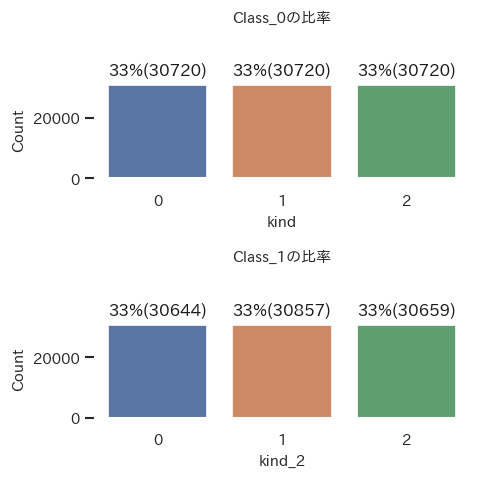

In [64]:
sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

nr, nc = 2, 1
fig, axes = plt.subplots(nr, nc, figsize=(500/dpi, 100*5/dpi), dpi=dpi, tight_layout=True, facecolor="w")

for i, (col, ax) in enumerate(zip(['kind', 'kind_2'], axes)):
  g = sns.countplot(data=data_, x=col, ax=ax)
  # set title
  g.set_title(f'Class_{i}の比率', fontsize=9, pad=35)

  ## tick
  g.tick_params(bottom=False, left=True, right=False, top=False,
                labelbottom=True, labelleft=True, labelright=False, labeltop=False,
                labelsize=9)
  sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
  # xlabel ylabel
  g.set_xlabel(f'{col}', fontsize=9)
  g.set_ylabel(f'Count', fontsize=9)
  for p in g.patches:
    g.annotate(f'{(p.get_height()/len(data_))*100:.0f}%({p.get_height():.0f})',
              (p.get_x() + p.get_width() / 2., p.get_height()), 
              ha = 'center', 
              va = 'center', 
              xytext = (0, 9), 
              textcoords = 'offset points',
              fontsize = 10,
              color = 'k')
plt.show()

In [65]:
split=3
data = MultilabelStratifiedGroupKFold_def(data_, 'id', ['kind', 'kind_2'], split, threshold=len(data_)/len(data_.id.unique()), random_state=random_state)

In [66]:
tmp = data['fold']
data = pd.get_dummies(data, columns=['fold'])
data = pd.concat([data,tmp], axis=1)

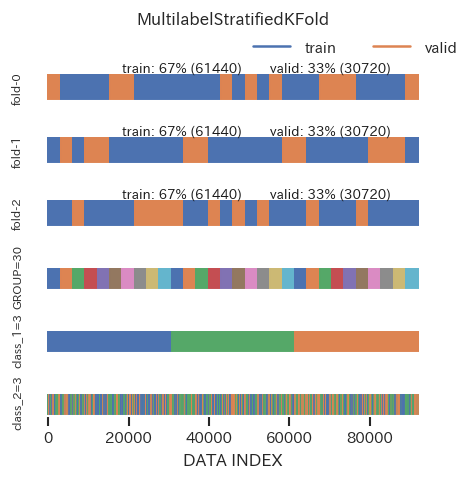

In [67]:
folds=[i for i in range(split)]

sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

dpi=120
nr, nc = len(folds)+3, 1
fig, axes = plt.subplots(nr, nc, figsize=(500/dpi, 100*5/dpi), dpi=dpi, tight_layout=True, facecolor="w")

for i, (fold, ax) in enumerate(zip(folds, axes)):
  if i == 0:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=True, ax=ax)

    # legend
    ## label name
    legend = g.get_legend()
    labels = [] if legend is None else [str(x._text) for x in legend.texts]
    handles = [] if legend is None else legend.legendHandles
    g.legend(handles, ["train", "valid"], title=None)
    ## move legend
    sns.move_legend(g, "lower center", bbox_to_anchor=(.8, 1.1), ncol=2, frameon=False)
    ## set font size legend
    plt.setp(g.get_legend().get_texts(), fontsize='9')
    plt.setp(g.get_legend().get_title(), fontsize='9') 
  else:
    g = sns.rugplot(data=data, x=data.index, hue=f"fold_{fold}", height=1, legend=False, ax=ax)

  # set title
  if i == 0:
    g.set_title(f'MultilabelStratifiedKFold', fontsize=10, pad=30)

  # tick
  g.tick_params(bottom=False, left=False, right=False, top=False,
                labelbottom=False, labelleft=False, labelright=False, labeltop=False,
                labelsize=9)
  sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

  # ylabel
  g.set_ylabel(f'fold-{fold}', fontsize=7)

  # Add text
  g.text(len(data)/2 -len(data)*0.3, 0.3, f'train: {len(data[data[f"fold_{fold}"] == 0])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 0])})', fontsize=8, color='k')
  g.text(len(data)/2 +len(data)*0.1, 0.3, f'valid: {len(data[data[f"fold_{fold}"] == 1])/len(data)*100:.0f}% ({len(data[data[f"fold_{fold}"] == 1])})', fontsize=8, color='k')


# plot ID
ax = axes[-3]
g = sns.rugplot(data=data, x=data.index, hue=f"id", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.id.unique())))
## tick
g.tick_params(bottom=False, left=False, right=False, top=False,
              labelbottom=False, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
## ylabel
g.set_ylabel(f'GROUP={len(data_.id.unique())}', fontsize=7)


# plot kind
ax = axes[-2]
g = sns.rugplot(data=data, x=data.index, hue=f"kind", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.kind.unique())))
## tick
g.tick_params(bottom=False, left=False, right=False, top=False,
              labelbottom=False, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
## ylabel
g.set_ylabel(f'class_1={len(data_.kind.unique())}', fontsize=7)

# plot kind_2
ax = axes[-1]
g = sns.rugplot(data=data, x=data.index, hue=f"kind_2", height=.8, legend=False, ax=ax, palette=sns.color_palette(n_colors=len(data_.kind.unique())))
## tick
g.tick_params(bottom=True, left=False, right=False, top=False,
              labelbottom=True, labelleft=False, labelright=False, labeltop=False,
              labelsize=9)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
## xlabel
g.set_xlabel("DATA INDEX", fontsize=10)
## ylabel
g.set_ylabel(f'class_2={len(data_.kind.unique())}', fontsize=7)

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

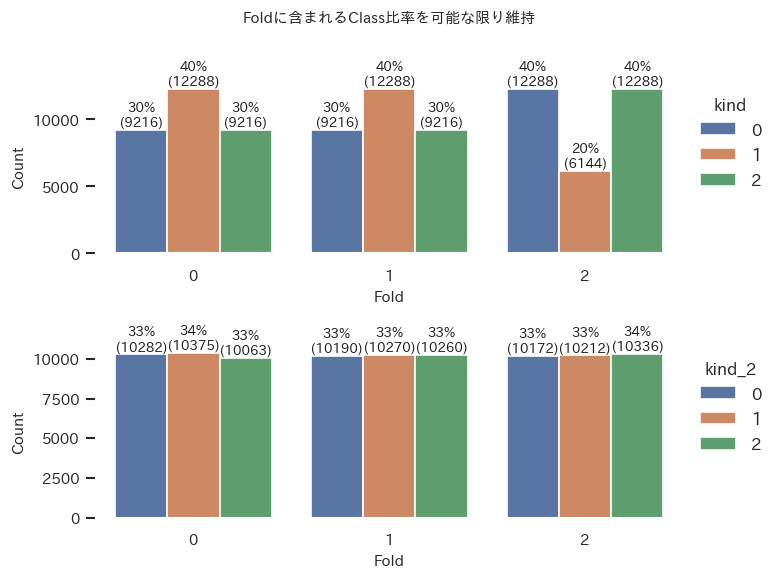

In [68]:
sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white','font.family':'IPAexGothic'})

nr, nc = 2, 1
fig, axes = plt.subplots(nr, nc, figsize=(800/dpi, 300*2/dpi), dpi=dpi, tight_layout=True, facecolor="w")

for i, (col, ax) in enumerate(zip(['kind', 'kind_2'], axes)):
  g = sns.countplot(data=data, x="fold", hue=col, ax=ax)
  if i == 0:
    # set title
    g.set_title(f'Foldに含まれるClass比率を可能な限り維持', fontsize=9, pad=35)
  ## move legend
  sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), ncol=1, frameon=False)
  ## set font size legend
  plt.setp(g.get_legend().get_texts(), fontsize='10')
  plt.setp(g.get_legend().get_title(), fontsize='10')
  ## tick
  g.tick_params(bottom=False, left=True, right=False, top=False,
                labelbottom=True, labelleft=True, labelright=False, labeltop=False,
                labelsize=9)
  sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
  # xlabel ylabel
  g.set_xlabel(f'Fold', fontsize=9)
  g.set_ylabel(f'Count', fontsize=9)
  j=0
  for p in g.patches:
    g.annotate(f'{(p.get_height()/len(data[data[f"fold_{j}"] == 1]))*100:.0f}%\n({p.get_height():.0f})',
              (p.get_x() + p.get_width() / 2., p.get_height()),
              ha = 'center',
              va = 'center',
              xytext = (0, 9),
              textcoords = 'offset points',
              fontsize = 8,
              color = 'k')
    j += 1
    if j >= split:
      j = 0
plt.show()

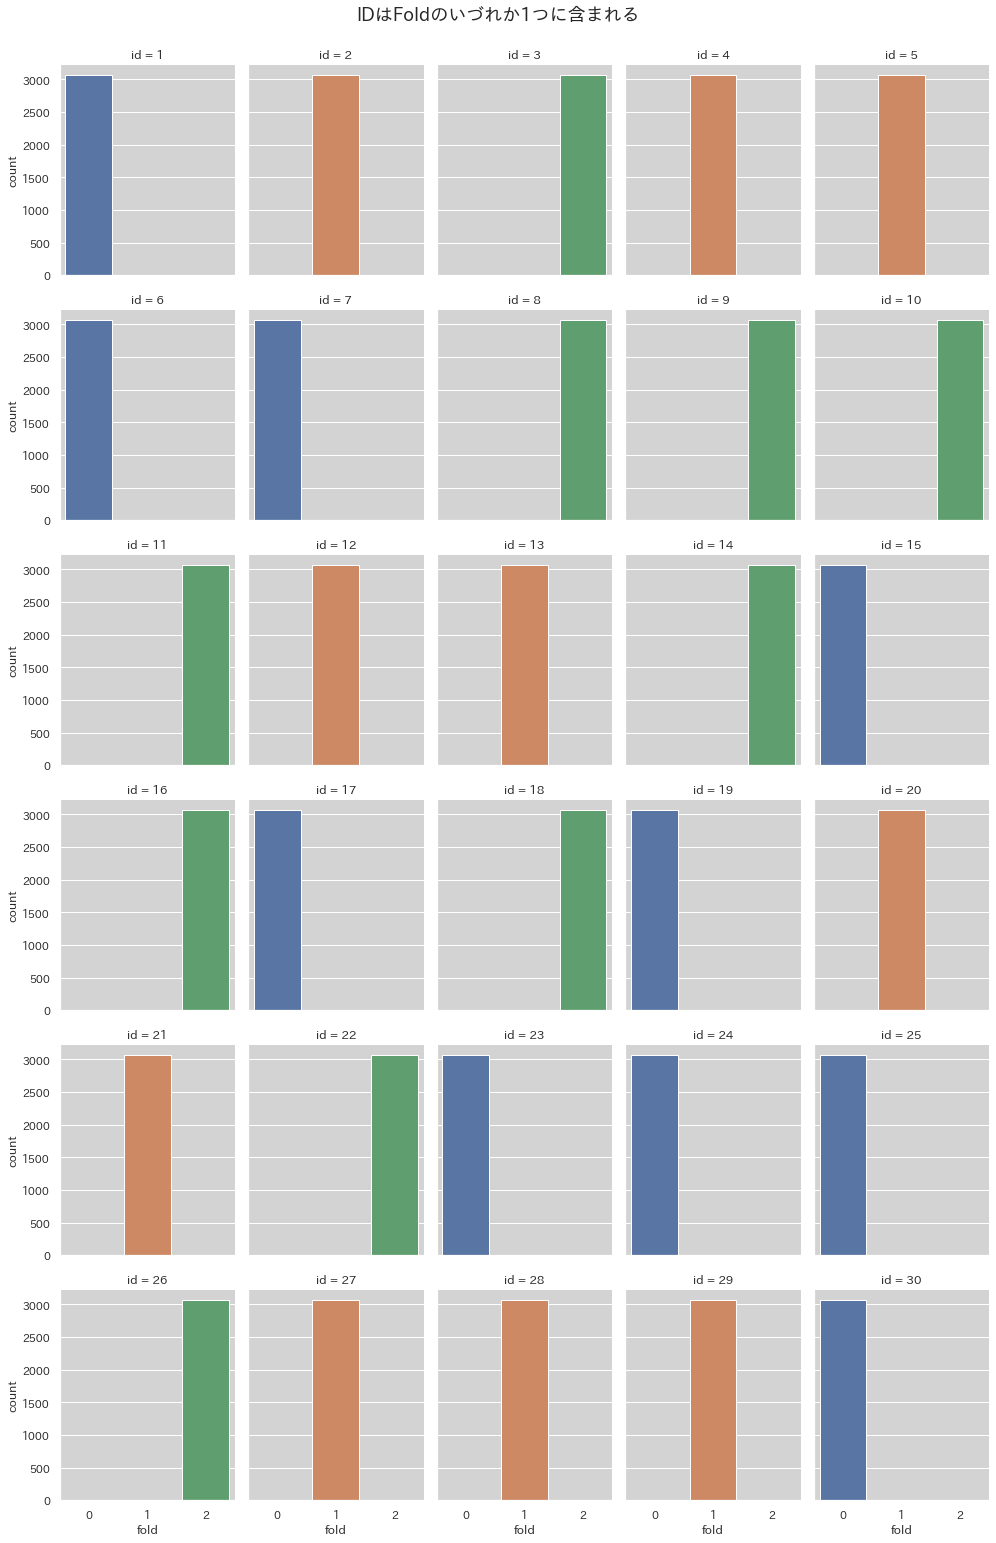

In [69]:
sns.set(rc={'axes.facecolor':'lightgrey','figure.facecolor':'white','font.family':'IPAexGothic'})
g = sns.catplot(data=data, x="fold", col="id", col_wrap=5,
                kind="count", height=3.5, aspect=.8)
# set title
g.fig.suptitle("IDはFoldのいづれか1つに含まれる", size=18, weight=2, x=.5, y=1.02)
plt.show()